In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [5]:
from tqdm import tqdm
tqdm.pandas()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Чтение данных из файла CSV в кодировке Windows-1251
themes = pd.read_csv(r'/content/drive/MyDrive/TextClassifier/themes.txt', encoding='utf-8', sep='\t')
df = pd.read_csv(r'/content/drive/MyDrive/TextClassifier/prod_mrt_ss.csv', encoding='utf-8', sep=',', dtype={1: str, 2: str, 3: str, 4: str})

In [ ]:
themes

,theme
0,Адресные указатели
1,Антропогенные ЧС / Зимние виды отдыха
2,Антропогенные ЧС / Крупные ДТП
3,Антропогенные ЧС / Несчастные случаи с рабочими
4,Антропогенные ЧС / Открытые и сломанные люки
...,...
221,Экопросвещение
222,Электроснабжение / Отключение электроснабжения
223,Электроснабжение / Плановое техобслуживание
224,Электроснабжение / Повреждение электропроводки


In [ ]:
df

,date,time,theme,title,post
0,2020-06-02,NaN,Природные ЧС / Затопления и иные последствия л...,Затопило переход под мостом,
1,2020-06-02,NaN,Содержание МКД / Содержание мусоропроводов,"Бескудниковская народная сказка о том, что сна...",Водители мусоровоза заезжают на газон
2,2020-06-03,NaN,Природные ЧС / Упавшие и поваленные деревья,На Шипиловской упало дерево,На Шипиловской упало дерево на машину
3,2020-06-03,NaN,"Содержание, устройство, покос, понижение газон...",Жилищник не сдержал обещание по благоустройств...,"На снимок попал ""лысый"" газон, который Жилищн..."
4,2020-06-03,NaN,Водоотведение / Прием и транспортировка сточны...,Что там у нас с ливневками в городе? На 70% ну...,Скоро и канализация по улицам разливаться начн...
...,...,...,...,...,...
554599,2023-07-21,04:34:02,Водоснабжение / Горячее водоснабжение,Критика по поводу не соблюдения сроков подачи...,"Кто из корпуса 129,предлагаю подать коллективн..."
554600,2023-07-21,04:38:15,Водоотведение / Прием и транспортировка сточны...,Критика по поводу качества работ по укладке а...,В Алёшкинском лесу эти дебилы тоже в асфальт о...
554601,2023-07-21,05:56:11,"Благоустройство вылетных магистралей, улиц и о...",В результате благоустройства двора по адресу:...,"Ко мне, как к депутату Совета депутатов муниц..."
554602,2023-07-21,06:20:08,Работа управляющей компании МКД,Критика по поводу помывки мусорного контейнера...,"Буквально в шаговой доступности, на соседней у..."


In [ ]:
df2 = pd.read_csv(r'/content/drive/MyDrive/TextClassifier/MRT.csv', encoding='utf-8', sep=',', dtype={1: str, 2: str, 3: str, 4: str})
df2.columns = ['date', 'theme', 'title', 'post']

In [ ]:
df3 = pd.read_csv(r'/content/drive/MyDrive/TextClassifier/Topic.csv', encoding='utf-8', sep=',', dtype={1: str, 2: str, 3: str, 4: str})

In [ ]:
df2

,date,theme,title,post
0,18.04.2021,Ремонт дорог / Плохое состояние покрытия и ямо...,Житель поселения Мосрентген пожаловался на ямы...,@moscow.dgkh и до сих пор не заделали эти дыры
1,18.04.2021,Уборка общественных пространств (летняя),Жители указали на скопление грязи возле Дома к...,Прошло два дня после публикации об антисанитар...
2,18.04.2021,"Благоустройство вылетных магистралей, улиц и о...",Жители поселения Мосрентген просят обновить кл...,Этим клумбам лет сорок. Такие теперь стоят в д...
3,18.04.2021,Водоотведение / Прием и транспортировка сточны...,Житель Молжаниновского района указывает на про...,Воду с частного участка напротив 15-го корпуса...
4,18.04.2021,"Благоустройство вылетных магистралей, улиц и о...","Жалоба на покрасочные работы ограждений, из-за...",Красный Казанец дом 1 корпус 1 Добрый день! Н...
...,...,...,...,...
44997,27.02.2022,Сопряженные земляные работы,Повреждение зеленых насаждений во время землян...,Департамент природопользования и охраны окружа...
44998,27.02.2022,"Благоустройство вылетных магистралей, улиц и о...",Житель указывает на необходимость благоустройс...,Большая Академическая между домом 81 и 79 корп...
44999,27.02.2022,Содержание МКД / Содержание и текущий ремонт дома,Разбито стекло на тамбурной двери подъезда в д...,"Новопеределкинская 12.1 подъезд 4 , нет слов. ..."
45000,27.02.2022,Содержание ООПТ,"В ходе инспекции выявлено, что ГБУ «Автомобиль...",В ходе инспекции ООПТ Ландшафтный заказник «До...


In [ ]:
df = pd.concat([df, df2], axis=0) # объединяем два датафрейма

In [ ]:
df = df[~df['theme'].isna()] #удаляем строки с отсутствующими значениями в столбце 'theme'

df['title_original'] = df['title'] #создаем новые столбцы 'title_original' и 'post_original', копируя значения из соответствующих столбцов 'title' и 'post'
df['post_original'] = df['post']

df['title'] = df['title'].fillna('') #замена отсутствующих значений (NaN) в столбцах 'title' и 'post' на пустые строки, это позволяет избежать проблем при обработке текстовых данных, где отсутствующие значения могут вызывать ошибки
df['post'] = df['post'].fillna('')

In [ ]:
word = r'Покровское-' #word = r'\bгор\.' (это регулярное выражение ищет подстроку 'гор.' с учетом границ слова)
contains_in_title = df['title'].str.contains(word).sum() #подсчет количества строк в столбце 'title', содержащих подстроку, соответствующую регулярному выражению в переменной 'word'
contains_in_prod = df['post'].str.contains(word).sum() #подсчет количества строк в столбце 'post', содержащих подстроку, соответствующую регулярному выражению в переменной 'word'
print(f"Содержит '{word}' в столбце 'title':\n", contains_in_title) #вывод количества строк, в которых найдена подстрока в столбце 'title'
print(f"Содержит '{word}' в столбце 'prod':\n", contains_in_prod)
df[df['title'].str.contains(word)]['title'].to_list()
df[df['post'].str.contains(word)]['post'].to_list() #вывод списка строк из столбца 'post', где найдена подстрока, соответствующая регулярному выражению в переменной 'word'

Содержит 'Покровское-' в столбце 'title':
 1066
Содержит 'Покровское-' в столбце 'prod':
 581


['МОЭСК убийца всего живого!\r\nЯ хочу им чего-то ужасного!\r\nМОЭС Кубивает экологию — злая в Район Покровское-Стрешнево, СЗАО.',
 'Вытесняют обитателей леса, уничтожают гнезда, лишают кормовой базы. Желна (черный дятел). На территории Москвы вид находился под особой охраной с 1978 по 1996 гг., в 2001 г. занесён в Красную книгу Москвы с КР 1. Все лесные массивы, где в период 1985-2010 гг. гнездилась желна, имеют статус ООПТ — НП «Лосиный Остров», П-ИП «Измайлово», «Кузьминки-Люблино», «Москворецкий», «Тушинский» и «Покровское-Стрешнево», КЗ «Петровско-Разумовское».',
 'Галина Величко жалуется в группе "Покровское-Стрешнево соседи", что на территории Храма Покрова Богородицы собирают листву. Так еще и от контактного зоопарка хлам не убрали...',
 'Не опять, а снова проблемы с водой. Фанта может стать "любимым" напитком наших соседей \nМарина Шумская из группы "Покровское-Стрешнево соседи" сделала это фото в своей квартире во Врачебном проезде. Повезло, что через 20 минут вода пошла норм

In [6]:
def generate_patterns_abbreviations(abbreviations):
    patterns = {}
    for abbreviation in abbreviations:
        # Для каждой аббревиатуры формируем регулярное выражение, которое соответствует ей в любом регистре
        regex = r'\b' + ''.join([f'[{char.upper()}{char.lower()}]' for char in abbreviation if char.isalpha()]) + r'\b'
        # Проверяем длину аббревиатуры
        if len(abbreviation) < 3:
            abbreviation = abbreviation + 'а' * (3 - len(abbreviation)) if len(abbreviation) < 3 else abbreviation  # Добавляем 'а' в конец, если аббревиатура меньше трёх букв
        patterns[regex] = abbreviation.lower()
    return patterns

def generate_patterns_names(abbreviations):
    patterns = {}
    for abbreviation in abbreviations:
        # Для каждой аббревиатуры формируем регулярное выражение, которое соответствует ей в любом регистре
        regex = r'\b' + ''.join([f'[{char.upper()}{char.lower()}]' for char in abbreviation if char.isalpha()]) + r'[А-Яа-я]*\b'
        patterns[regex] = abbreviation.lower()
    return patterns

patterns = {
    'ё': 'е',
    'Ё': 'Е',
    r'\b\d+[-А-Яа-я0-9]*\b': ' ', # цифры формата "3ий", "44ая" и т.д. (выражение соответствует последовательности цифр, за которой может следовать комбинация из дефисов, букв и цифр)
    # r'\b\d+-[А-Яа-яьъ]+\b': ' ', # цифры формата "3-ий" и т.д.
    r'\.+': '.', # заменяет найденные последовательности точек на одиночные точки
    r'\b[А-Я]\.[А-Я]\.[А-Я][а-я]+\b': ' ', # формат для инициалов и фамилии
    r'\b[Уу][Лл]\.': 'улица ', #"ул." или "Ул." в тексте заменит на полное слово "улица" с последующим пробелом
    r'\b[Пп][Рр]\.': ' ', # заменяет сокращенное обозначение "пр." или "Пр." на пробел
    r'\bд\.': 'дом', # заменяет сокращенное обозначение "д." на слово "дом"
    r'\bк\.': 'квартира', # заменяет сокращенное обозначение "к." на слово "квартира"
    'Покровское-Стрешнево': 'покровскоестрешнево',
    '''"Мой район"''': 'мойрайон',
    r'\bДО\b': 'доа' # заменяет отдельно стоящее слово "ДО" на "доа" (с учетом границ слова)
    }

abbreviations = set(['COVID', 'ФГУП', 'МОЭК', 'ПГМ', 'ЮВХ', 'ППЗ', 'АЗС', 'МЗП', 'МЖИ', 'ДКР', 'НИИ', 'МЧС', 'ФКР', 'ООС', 'ХВС', 'ГВС', 'ПСД', 'ЖК', 'ООО', 'МГД', 'ДПиОС', 'ЮВХ', 'ЖК', 'ГХ', 'ГД', 'РФ', 'ОГО', 'ГТ', 'ЧС', 'ЗиЦН', 'ПГМ', 'ГБУ', 'МКД', 'ЖКХ', 'ДТП', 'КГХ', 'МГУ', 'ООПТ', 'ПиП', 'ДРК', 'МО', 'ЛКСМ', 'МГО', 'МГД', 'СД', 'ПАО'])

names = set(['Шиес', 'Михаили', 'Жилищник', 'Кусков', 'Яуз', 'Битцевский', 'Радон', 'Борщевик'])

patterns.update(generate_patterns_abbreviations(abbreviations)) #добавляет в словарь patterns новые записи для аббревиатур
patterns.update(generate_patterns_names(names)) #  добавляет новые записи для имен

In [7]:
patterns

{'ё': 'е',
 'Ё': 'Е',
 '\\b\\d+[-А-Яа-я0-9]*\\b': ' ',
 '\\.+': '.',
 '\\b[А-Я]\\.[А-Я]\\.[А-Я][а-я]+\\b': ' ',
 '\\b[Уу][Лл]\\.': 'улица ',
 '\\b[Пп][Рр]\\.': ' ',
 '\\bд\\.': 'дом',
 '\\bк\\.': 'квартира',
 'Покровское-Стрешнево': 'покровскоестрешнево',
 '"Мой район"': 'мойрайон',
 '\\bДО\\b': 'доа',
 '\\b[Нн][Ии][Ии]\\b': 'нии',
 '\\b[Мм][Гг][Уу]\\b': 'мгу',
 '\\b[Пп][Сс][Дд]\\b': 'псд',
 '\\b[Пп][Гг][Мм]\\b': 'пгм',
 '\\b[Дд][Кк][Рр]\\b': 'дкр',
 '\\b[Гг][Хх]\\b': 'гха',
 '\\b[Кк][Гг][Хх]\\b': 'кгх',
 '\\b[Жж][Кк][Хх]\\b': 'жкх',
 '\\b[Гг][Бб][Уу]\\b': 'гбу',
 '\\b[Оо][Гг][Оо]\\b': 'ого',
 '\\b[Хх][Вв][Сс]\\b': 'хвс',
 '\\b[Оо][Оо][Сс]\\b': 'оос',
 '\\b[Гг][Дд]\\b': 'гда',
 '\\b[Оо][Оо][Пп][Тт]\\b': 'оопт',
 '\\b[Дд][Тт][Пп]\\b': 'дтп',
 '\\b[Зз][Ии][Цц][Нн]\\b': 'зицн',
 '\\b[Пп][Аа][Оо]\\b': 'пао',
 '\\b[Мм][Кк][Дд]\\b': 'мкд',
 '\\b[Фф][Гг][Уу][Пп]\\b': 'фгуп',
 '\\b[Сс][Дд]\\b': 'сда',
 '\\b[Мм][Жж][Ии]\\b': 'мжи',
 '\\b[Рр][Фф]\\b': 'рфа',
 '\\b[Гг][Тт]\\b': 'гта',
 '\\b[Мм][З

In [ ]:
# замена паттернов
for key, value in tqdm(patterns.items()):
    df['title'] = df['title'].str.replace(key, value, regex=True)
    df['post'] = df['post'].str.replace(key, value, regex=True)

100%|██████████| 62/62 [03:23<00:00,  3.29s/it]


In [ ]:
df

,date,time,theme,title,post,title_original,post_original
0,2020-06-02,NaN,Природные ЧС / Затопления и иные последствия л...,Затопило переход под мостом,,Затопило переход под мостом,
1,2020-06-02,NaN,Содержание МКД / Содержание мусоропроводов,"Бескудниковская народная сказка о том, что сна...",Водители мусоровоза заезжают на газон,"Бескудниковская народная сказка о том, что сна...",Водители мусоровоза заезжают на газон
2,2020-06-03,NaN,Природные ЧС / Упавшие и поваленные деревья,На Шипиловской упало дерево,На Шипиловской упало дерево на машину,На Шипиловской упало дерево,На Шипиловской упало дерево на машину
3,2020-06-03,NaN,"Содержание, устройство, покос, понижение газон...",жилищник не сдержал обещание по благоустройств...,"На снимок попал ""лысый"" газон, который жилищн...",Жилищник не сдержал обещание по благоустройств...,"На снимок попал ""лысый"" газон, который Жилищн..."
4,2020-06-03,NaN,Водоотведение / Прием и транспортировка сточны...,Что там у нас с ливневками в городе? На % нуж...,Скоро и канализация по улицам разливаться начн...,Что там у нас с ливневками в городе? На 70% ну...,Скоро и канализация по улицам разливаться начн...
...,...,...,...,...,...,...,...
44997,27.02.2022,NaN,Сопряженные земляные работы,Повреждение зеленых насаждений во время землян...,Департамент природопользования и охраны окружа...,Повреждение зеленых насаждений во время землян...,Департамент природопользования и охраны окружа...
44998,27.02.2022,NaN,"Благоустройство вылетных магистралей, улиц и о...",Житель указывает на необходимость благоустройс...,Большая Академическая между домом и корпус...,Житель указывает на необходимость благоустройс...,Большая Академическая между домом 81 и 79 корп...
44999,27.02.2022,NaN,Содержание МКД / Содержание и текущий ремонт дома,Разбито стекло на тамбурной двери подъезда в д...,"Новопеределкинская . подъезд , нет слов. ...",Разбито стекло на тамбурной двери подъезда в д...,"Новопеределкинская 12.1 подъезд 4 , нет слов. ..."
45000,27.02.2022,NaN,Содержание ООПТ,"В ходе инспекции выявлено, что гбу «Автомобиль...",В ходе инспекции оопт Ландшафтный заказник «До...,"В ходе инспекции выявлено, что ГБУ «Автомобиль...",В ходе инспекции ООПТ Ландшафтный заказник «До...


In [8]:
# Функция для предобработки данных для удаления имён собственных
def format_string(text):
    if not text:  # Проверка на пустую строку
        return text

    # Переводим первую букву в нижний регистр
    text = text[0].lower() + text[1:]

    # Функция для замены букв после точки и пробелов на нижний регистр
    def lower_after_dot(match):
        return match.group(1) + match.group(2).lower()

    # Применяем регулярное выражение для замены
    text = re.sub(r'(\.\s*)(\w)', lower_after_dot, text)

    # Удаляем все слова которые начинаются с большой буквы
    text = ' '.join(word for word in text.split() if not word[0].isupper())

    return text

In [ ]:
# Очистка текста
df['title'] = df['title'].str.replace('[^а-яА-Я]', ' ', regex=True) #заменяем все символы, не являющиеся буквами русского алфавита, на пробелы
df['title'] = df['title'].progress_apply(format_string) # удаляем имена собственные
df['title'] = df['title'].str.lower() # приводим все символы к нижнему регистру

df['post'] = df['post'].str.replace('[^а-яА-Я]', ' ', regex=True) # оставляем только русские символы
df['post'] = df['post'].progress_apply(format_string) # удаляем имена собственные
df['post'] = df['post'].str.lower() # приводим все символы к нижнему регистру

# df['text'] = df['text'].fillna('').apply(lambda text: ' '.join(word for word in text.split() if len(word) > 3))
# df['title'] = df['title'].progress_apply(lambda text: ' '.join(word for word in text.split() if not word[0].isupper())) #применяем функцию lambda для удаления слов, начинающихся с заглавной буквы (удаляет имена собственные), оставшиеся слова объединяются обратно в текст с пробелами между ними

100%|██████████| 204961/204961 [00:03<00:00, 65575.74it/s]


In [ ]:
df

,date,time,theme,title,post,title_original,post_original
0,2020-06-02,NaN,Природные ЧС / Затопления и иные последствия л...,затопило переход под мостом,,Затопило переход под мостом,
1,2020-06-02,NaN,Содержание МКД / Содержание мусоропроводов,бескудниковская народная сказка о том что снач...,водители мусоровоза заезжают на газон,"Бескудниковская народная сказка о том, что сна...",Водители мусоровоза заезжают на газон
2,2020-06-03,NaN,Природные ЧС / Упавшие и поваленные деревья,на упало дерево,на упало дерево на машину,На Шипиловской упало дерево,На Шипиловской упало дерево на машину
3,2020-06-03,NaN,"Содержание, устройство, покос, понижение газон...",жилищник не сдержал обещание по благоустройств...,на снимок попал лысый газон который жилищник о...,Жилищник не сдержал обещание по благоустройств...,"На снимок попал ""лысый"" газон, который Жилищн..."
4,2020-06-03,NaN,Водоотведение / Прием и транспортировка сточны...,что там у нас с ливневками в городе нуждаются ...,скоро и канализация по улицам разливаться начн...,Что там у нас с ливневками в городе? На 70% ну...,Скоро и канализация по улицам разливаться начн...
...,...,...,...,...,...,...,...
44997,27.02.2022,NaN,Сопряженные земляные работы,повреждение зеленых насаждений во время землян...,департамент природопользования и охраны окружа...,Повреждение зеленых насаждений во время землян...,Департамент природопользования и охраны окружа...
44998,27.02.2022,NaN,"Благоустройство вылетных магистралей, улиц и о...",житель указывает на необходимость благоустройс...,большая между домом и корпус года ждем благоус...,Житель указывает на необходимость благоустройс...,Большая Академическая между домом 81 и 79 корп...
44999,27.02.2022,NaN,Содержание МКД / Содержание и текущий ремонт дома,разбито стекло на тамбурной двери подъезда в д...,новопеределкинская подъезд нет слов минут наза...,Разбито стекло на тамбурной двери подъезда в д...,"Новопеределкинская 12.1 подъезд 4 , нет слов. ..."
45000,27.02.2022,NaN,Содержание ООПТ,в ходе инспекции выявлено что гбу дороги прово...,в ходе инспекции оопт заказник реки выявлено ч...,"В ходе инспекции выявлено, что ГБУ «Автомобиль...",В ходе инспекции ООПТ Ландшафтный заказник «До...


In [ ]:
# Удаление стоп-слов
import nltk

# Загрузка русских стоп-слов
nltk.download('stopwords')
nltk.download('punkt') # загружает инструменты для токенизации
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

russian_stopwords = stopwords.words('russian') # перменная cодержит список стоп-слов для русского языка

# Функция для удаления стоп-слов из текста
def remove_stop_words(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in russian_stopwords] #cоздаем список 'filtered_words', содержащий слова из токенизированного текста, которые не являются стоп-словами на русском языке, каждое слово приводится к нижнему регистру
    return ' '.join(filtered_words) #отфильтрованные слова объединяются обратно в текст, разделяя их пробелами

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\4793788\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\4793788\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Удаление стоп-слов
df['title'] = df['title'].progress_apply(remove_stop_words)
df['post'] = df['post'].progress_apply(remove_stop_words)

100%|██████████| 206323/206323 [01:19<00:00, 2591.06it/s] 


In [ ]:
df

,date,time,theme,title,post,title_original,post_original
0,2020-06-02,NaN,Природные ЧС / Затопления и иные последствия л...,затопило переход мостом,,Затопило переход под мостом,
1,2020-06-02,NaN,Содержание МКД / Содержание мусоропроводов,бескудниковская народная сказка сначала семь о...,водители мусоровоза заезжают газон,"Бескудниковская народная сказка о том, что сна...",Водители мусоровоза заезжают на газон
2,2020-06-03,NaN,Природные ЧС / Упавшие и поваленные деревья,упало дерево,упало дерево машину,На Шипиловской упало дерево,На Шипиловской упало дерево на машину
3,2020-06-03,NaN,"Содержание, устройство, покос, понижение газон...",жилищник сдержал обещание благоустройству газона,снимок попал лысый газон который жилищник обещ...,Жилищник не сдержал обещание по благоустройств...,"На снимок попал ""лысый"" газон, который Жилищн..."
4,2020-06-03,NaN,Водоотведение / Прием и транспортировка сточны...,ливневками городе нуждаются замене,скоро канализация улицам разливаться начнет ка...,Что там у нас с ливневками в городе? На 70% ну...,Скоро и канализация по улицам разливаться начн...
...,...,...,...,...,...,...,...
44997,27.02.2022,NaN,Сопряженные земляные работы,повреждение зеленых насаждений время земляных ...,департамент природопользования охраны окружающ...,Повреждение зеленых насаждений во время землян...,Департамент природопользования и охраны окружа...
44998,27.02.2022,NaN,"Благоустройство вылетных магистралей, улиц и о...",житель указывает необходимость благоустройства...,большая домом корпус года ждем благоустройства...,Житель указывает на необходимость благоустройс...,Большая Академическая между домом 81 и 79 корп...
44999,27.02.2022,NaN,Содержание МКД / Содержание и текущий ремонт дома,разбито стекло тамбурной двери подъезда доме у...,новопеределкинская подъезд слов минут назад пр...,Разбито стекло на тамбурной двери подъезда в д...,"Новопеределкинская 12.1 подъезд 4 , нет слов. ..."
45000,27.02.2022,NaN,Содержание ООПТ,ходе инспекции выявлено гбу дороги проводит уб...,ходе инспекции оопт заказник реки выявлено гбу...,"В ходе инспекции выявлено, что ГБУ «Автомобиль...",В ходе инспекции ООПТ Ландшафтный заказник «До...


In [ ]:
!pip install pymorphy3

In [ ]:
# Лемматизация
import pymorphy3
from concurrent.futures import ThreadPoolExecutor

# Инициализация анализатора pymorphy3
morph = pymorphy3.MorphAnalyzer()

# Функция для лемматизации текста
def lemmatize_text(text):
    return ' '.join([morph.parse(word)[0].normal_form for word in text.split()]) #преобразует каждое слово в его нормальную форму

# Функция для обработки пакета текстов
def process_batch(texts):
    return [lemmatize_text(text) for text in texts]

# Разбиение данных на пакеты
def batch(iterable, batch_size=500):
    for ndx in range(0, len(iterable), batch_size):
        yield iterable[ndx:min(ndx + batch_size, len(iterable))]

In [ ]:
# Лемматизация
for col in ['title', 'post']:
    batches = list(batch(df[col]))
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(process_batch, batches), total=len(batches)))

        # Объединение результатов
        df[col] = [lemmatized_text for batch_result in results for lemmatized_text in batch_result]

100%|██████████| 413/413 [26:58<00:00,  3.92s/it] 


In [ ]:
# Разделяем текст на слова и фильтруем слова длиной меньше 3 символов (cоздаем список текстов, объединяя тексты из столбцов 'title' и 'post')
words = set(word for phrase in df['title'].tolist() + df['post'].tolist() for word in phrase.split() if len(word) < 3)

# Выводим каждое слово с новой строки
for word in words:
    print(word)

вк
сн
нп
си
тц
ов
дю
др
чп
ут
пк
ге
вн
щ
ищ
пм
мм
кр
ч
ша
зэ
чь
хд
яй
нх
сс
ое
ас
жт
еб
зд
уч
зз
аш
хр
жо
оп
жи
дт
ям
зо
п
юв
тя
яб
ещ
жд
кс
фо
мз
бх
ад
рж
вэ
ош
кг
чр
мб
оз
ты
тб
дл
ди
лн
ио
жн
эк
ня
нэ
ь
ды
мн
к
му
го
ги
рм
б
кп
хи
мк
пя
аа
ки
фу
юд
цы
ос
оу
пы
лу
ны
мд
уд
св
зю
вд
ль
жб
ля
юж
ши
пс
уи
эл
ма
яд
ют
вй
чч
шт
оф
че
ич
нк
ху
бк
фп
уб
эн
ой
пд
нр
ум
лп
ир
юк
чб
нн
ет
шу
мж
тн
мр
мо
тп
вт
кв
бр
нш
ла
эм
вс
щи
ул
зм
сх
га
гл
ор
зе
уе
хм
кк
пт
вл
ау
эы
лю
зы
ит
мс
нс
хз
уф
сы
жю
ус
пп
бэ
ая
м
дк
гк
фа
яя
ру
хх
цо
жж
ые
нь
хв
рн
ву
ы
ог
ц
ёж
ои
хо
кл
ро
ят
мг
ст
тм
пф
н
чц
сь
чу
нв
ар
хн
лы
ть
ак
тч
зр
бп
ду
фи
ек
ер
дб
бу
бо
фб
ск
пн
дс
ао
яв
й
зн
шл
юр
х
пи
су
р
рб
мэ
бл
он
мв
ве
вп
гм
ух
еа
фм
аж
яс
пж
тв
сп
гу
гр
дн
тс
оо
пч
ил
ох
мф
бю
мы
пл
фр
нг
ук
эх
ся
тз
дд
дп
тю
сл
эй
шь
ик
хе
ай
э
пц
юг
ым
л
сб
ча
рк
вх
ю
вы
ес
ий
жа
уй
гв
ед
от
ле
лс
ап
би
дв
цм
г
уж
ом
ип
ую
бц
уп
тд
ф
сф
ян
са
пв
рт
лт
вю
эт
ив
уш
кн
рэ
дь
ег
мл
гы
пр
чи
ще
зб
из
лг
бз
цв
чм
тг
бь
ва
ба
нт
вм
э

In [ ]:
df[df.apply(lambda row: row.astype(str).str.contains(' ье').any(), axis=1)] #останутся только те строки, в которых хотя бы в одном из столбцов содержится строка с подстрокой ' ье'

,date,time,theme,title,post,title_original,post_original
47013,2021-09-25,05:00:42,Электроснабжение / Плановое техобслуживание,житель критиковать связь окончание срок беспла...,ожидать сентябрь остаться день срок ьесплатный...,Житель критикует АО «Мосэнергосбыт» в связи с ...,[club26944193:bp-26944193_12918|АО «Мосэнергос...
551427,2023-06-29,15:47:50,Пруды / Состояние воды пруда,житель интересоваться почему весь вода корпус ...,ий корпус улица дом ого корпус,"Житель интересуется, почему вся вода от 3-го к...","[club73411051|Ясное Ясенево М125], ПОЧЕМУ ВСЯ ..."
20051,25.09.2021,NaN,Электроснабжение / Плановое техобслуживание,житель критиковать связь окончание срок беспла...,ожидать сентябрь остаться день срок ьесплатный...,Житель критикует АО «Мосэнергосбыт» в связи с ...,[club26944193:bp-26944193_12918|АО «Мосэнергос...


In [9]:
# преобразуем столбец 'date' DataFrame df в формат даты и времени
def parse_date(date_str):
    for fmt in ('%Y-%m-%d', '%d.%m.%Y'):  # Добавьте больше форматов при необходимости
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            continue
    return pd.NaT  # Возвращается, если ни один формат не подходит

# Применение функции ко всем строкам в столбце 'date'
df['date'] = df['date'].apply(parse_date)

In [10]:
# создаём два списка тем для двух периодов времени на основе заданных критериев
months = [4, 5, 6, 7, 8, 9, 10]
# Сначала мы определим функцию для создания списка тем, удовлетворяющих заданным критериям
def create_theme_list(df, months, threshold):
    # Фильтруем данные по месяцам
    df_months = df[df['date'].dt.month.isin(months)] # включает только те строки, где значения в столбце 'date' соответствуют месяцам, указанным в списке months
    df_other_months = df[~df['date'].dt.month.isin(months)] # включает только строки, где значения в столбце 'date' не соответствуют месяцам, указанным в списке months

    # Группируем данные по темам и считаем количество вхождений
    count_in_months = df_months['theme'].value_counts() # подсчитываем количество вхождений каждой уникальной темы в DataFrame df_months, который содержит только строки, соответствующие указанным месяцам
    count_total = df['theme'].value_counts() # подсчитывает количество вхождений каждой уникальной темы в исходном DataFrame df

    # Фильтруем темы, которые встречаются в выбранных месяцах более чем на заданный процент и общее количество больше порога
    theme_list = count_in_months[(count_in_months / count_total >= threshold) & (count_total > 20)].index.tolist() # содержит список тем, которые встречаются в указанных месяцах более чем на заданный процент от общего количества вхождений и общее количество вхождений которых превышает 20

    return theme_list

# Создание списка тем для каждого периода
theme_for_del_period1 = create_theme_list(df, [month for month in range(1, 13) if month not in months], 0.80) # создается список тем для периода, включающего месяцы, которые не входят в указанный список months
theme_for_del_period2 = create_theme_list(df, months, 0.80) # создается список тем для периода, включающего только месяцы, указанные в списке months

print('Период:', months, '\nКол-во тем:', len(theme_for_del_period1))
print(theme_for_del_period1)
print()
print('Период:', [month for month in range(1, 13) if month not in months], '\nКол-во тем:', len(theme_for_del_period2))
print(theme_for_del_period2)

Период: [4, 5, 6, 7, 8, 9, 10] 
Кол-во тем: 14
['Содержание дорог / Уборка (зимняя)', 'Содержание придомовых территорий, дворов / Уборка зимняя', 'Уборка общественных пространств (зимняя)', 'Содержание придомовых территорий, дворов / ПГМ-обработка', 'Содержание МКД / Содержание и уборка кровли', 'Содержание дорог / ПГМ-обработка', 'Уборка общественных пространств (ПГМ)', 'Антропогенные ЧС / Падение снега и сосулек', 'Содержание придомовых территорий, дворов / Спортивные площадки', 'Обвинения в неправомерности', 'ПГМ-обработка тоннелей, мостов, переходов', 'Снег и снегосплавные пункты', 'Природные ЧС / Снегопады и завалы', 'Антропогенные ЧС / Зимние виды отдыха']

Период: [1, 2, 3, 11, 12] 
Кол-во тем: 62
['Благоустройство вылетных магистралей, улиц и общественных пространств', 'Ремонт  придомовых территорий, дворов /  Детские площадки ', 'Природные ЧС / Упавшие и поваленные деревья', 'Посадка, уход, пересадка зеленых и цветочных насаждений / Уход за ЗиЦН', 'Содержание, устройство, поко

In [ ]:
# Количество строк до фильтрации
initial_count_period1 = df[df['date'].dt.month.isin(months)].shape[0] # Считает количество строк в DataFrame, где значения в столбце 'date' соответствуют месяцам, указанным в списке months
initial_count_period2 = df[~df['date'].dt.month.isin(months)].shape[0] # Считает количество строк в DataFrame, где значения в столбце 'date' не соответствуют месяцам, указанным в списке months

# Фильтрация данных
df_period1 = df[df['date'].dt.month.isin(months) & ~df['theme'].isin(theme_for_del_period1)] # Включает только те строки, где значения в столбце 'date' соответствуют месяцам, указанным в списке months, и значения в столбце 'theme' не входят в список theme_for_del_period1
df_period2 = df[~df['date'].dt.month.isin(months) & ~df['theme'].isin(theme_for_del_period2)] # Включает только те строки, где значения в столбце 'date' не соответствуют месяцам, указанным в списке months, и значения в столбце 'theme' не входят в список theme_for_del_period2

# Количество строк после фильтрации
final_count_period1 = df_period1.shape[0] # Считает количество строк в DataFrame df_period1, который включает только те строки, где значения в столбце 'date' соответствуют месяцам, указанным в списке months, и значения в столбце 'theme' не входят в список theme_for_del_period1
final_count_period2 = df_period2.shape[0] # Считает количество строк в DataFrame df_period2, который включает только те строки, где значения в столбце 'date' не соответствуют месяцам, указанным в списке months, и значения в столбце 'theme' не входят в список theme_for_del_period2

# Вычисление удаленных строк
deleted_rows_period1 = initial_count_period1 - final_count_period1 # Вычисляет количество удаленных строк для первого периода времени путем вычитания конечного количества строк (final_count_period1) из начального количества строк (initial_count_period1).
deleted_rows_period2 = initial_count_period2 - final_count_period2 # Вычисляет количество удаленных строк для второго периода времени путем вычитания конечного количества строк (final_count_period2) из начального количества строк (initial_count_period2)

print(f"Удалено строк из df_period1: {deleted_rows_period1}")
print(f"Удалено строк из df_period2: {deleted_rows_period2}")

del initial_count_period1, initial_count_period2, final_count_period1, final_count_period2, deleted_rows_period1, deleted_rows_period2

Удалено строк из df_period1: 426
Удалено строк из df_period2: 4950


In [ ]:
df_period1[df['theme'] == 'Содержание, устройство, покос, понижение газонов / Покос газона']

C:\Users\4793788\AppData\Local\Temp\ipykernel_11456\1965151959.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_period1[df['theme'] == 'Содержание, устройство, покос, понижение газонов / Покос газона']
C:\Users\4793788\AppData\Local\Temp\ipykernel_11456\1965151959.py:1: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  df_period1[df['theme'] == 'Содержание, устройство, покос, понижение газонов / Покос газона']


ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
df['title'] = df['title'].apply(lambda text: ' '.join(word for word in text.split() if len(word)>=3))
df['post'] = df['post'].apply(lambda text: ' '.join(word for word in text.split() if len(word)>=3)) #останутся только те слова, длина которых больше или равна 3 символам, а все остальные слова будут удалены

In [11]:
# Функция для предобработки строки текста
def preprocess_text(text):
    if isinstance(text, str):
        for key, value in patterns.items(): # заменяем патерны из словаря patterns
            text = text.replace(key, value)

        text = format_string(text) # удаляем имена собственные
        text = re.sub(r'[^а-яА-Я]', ' ', text) # оставляем только русские символы
        text = ' '.join(word for word in text.split() if not word[0].isupper()) # удаляем имена собственные
        text = text.lower() # приводим к нижнему регистру

        # лемматизация
        text = lemmatize_text(text)
        text = ' '.join(word for word in text.split() if len(word)>=3) # разделяем текст на слова и фильтруем слова длиной меньше 3 символов
        return text

    elif isinstance(text, pd.Series):
        for key, value in tqdm(patterns.items()): # заменяем патерны из словаря patterns
            text = text.str.replace(key, value, regex=True)

        text = text.fillna('') # заменяем пропуски
        text = text.progress_apply(format_string) # удаляем имена собственные
        text = text.str.replace('[^а-яА-Я]', ' ', regex=True) # оставляем только русские символы
        text = text.progress_apply(lambda text: ' '.join(word for word in text.split() if not word[0].isupper())) # удаляем имена собственные
        text = text.str.lower() # приводим к нижнему регистру

        # лемматизация
        batches = list(batch(text))
        with ThreadPoolExecutor() as executor:
            results = list(tqdm(executor.map(process_batch, batches), total=len(batches)))
            # Объединение результатов
            text = [lemmatized_text for batch_result in results for lemmatized_text in batch_result]

        text = pd.Series(text)
        text = text.apply(lambda text: ' '.join(word for word in text.split() if len(word)>=3)) # разделяем текст на слова и фильтруем слова длиной меньше 3 символов

        return text

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Функция для векторизации текста с возможностью ограничения количества слов
def vectorize_text(text_or_series, max_features=None):
    # Инициализация векторизатора с учетом max_features
    vectorizer = TfidfVectorizer(max_features=max_features)

    # Векторизация текста
    if isinstance(text_or_series, pd.Series):
        # Если на входе pd.Series, применяем векторизатор к серии
        vectorized_text = vectorizer.fit_transform(text_or_series)
    elif isinstance(text_or_series, str):
        # Если на входе строка, преобразуем ее в список и векторизуем
        vectorized_text = vectorizer.fit_transform([text_or_series])
    else:
        raise ValueError("Input must be a string or a pandas Series.")

    return vectorized_text

In [ ]:
# Пример использования функции
text = "Пример текста для векторизации."
series = pd.Series(["Текст один.", "Еще один текст, для векторизации!"])

# Векторизация без ограничения количества слов
print(vectorize_text(text))

# Векторизация с ограничением в 1000 слов
print(vectorize_text(series))
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(series)
print(X)

  (0, 0)	0.5
  (0, 1)	0.5
  (0, 3)	0.5
  (0, 2)	0.5
  (0, 3)	0.7071067811865475
  (0, 4)	0.7071067811865475
  (1, 0)	0.4992213265230509
  (1, 1)	0.4992213265230509
  (1, 2)	0.4992213265230509
  (1, 3)	0.35520008546852583
  (1, 4)	0.35520008546852583
  (0, 3)	0.7071067811865475
  (0, 4)	0.7071067811865475
  (1, 0)	0.4992213265230509
  (1, 1)	0.4992213265230509
  (1, 2)	0.4992213265230509
  (1, 3)	0.35520008546852583
  (1, 4)	0.35520008546852583


In [6]:
df = pd.read_pickle('/content/drive/MyDrive/TextClassifier/dataframe_ver_6.pkl')

In [7]:
upsample = pd.read_pickle('/content/drive/MyDrive/TextClassifier/upsampling_v2.pkl')

In [7]:
for i in upsample[upsample['theme'] == 'Демонтаж, ремонт и установка декоративного наружного освещения / Установка иллюминации и праздничного светового оформления']['title_original'].to_list():
    print(i)

Требуется установка иллюминации на площади Тверской.
Неисправные гирлянды на улице Гоголя, опасность для прохожих.
Просьба заменить выгоревшие лампы в праздничной подсветке на бульваре Ринг.
Отсутствует новогодняя иллюминация в сквере Лермонтова.
Жители просят добавить уличное освещение к Рождественским украшениям.
Поврежденные световые установки на входе в парк Горького.
Нарушения безопасности при монтаже уличной подсветки.
Отсутствие декоративного освещения на проспекте Мира.
Жалобы на неправильное расположение праздничных фонарей.
Некачественное выполнение работ по установке иллюминации.
Необходима дополнительная иллюминация на Красной площади.
Жители жалуются на отсутствие светового оформления в парке Сокольники.
Сломанная гирлянда улице Баумана представляет опасность.
Требуется срочный ремонт поврежденных световых украшений на Арбате.
Отключение иллюминации в ночное время в районе Чистых прудов.
Проблемы с электропитанием праздничного освещения на Кутузовском проспекте.
Нарушение 

In [8]:
df

,date,time,theme,title,post,title_original,post_original
0,2020-06-02,NaN,Природные ЧС / Затопления и иные последствия л...,затопить переход мост,,Затопило переход под мостом,
1,2020-06-02,NaN,Содержание МКД / Содержание мусоропроводов,бескудниковский народный сказка сначала семь о...,водитель мусоровоз заезжать газон,"Бескудниковская народная сказка о том, что сна...",Водители мусоровоза заезжают на газон
2,2020-06-03,NaN,Природные ЧС / Упавшие и поваленные деревья,упасть дерево,упасть дерево машина,На Шипиловской упало дерево,На Шипиловской упало дерево на машину
3,2020-06-03,NaN,"Содержание, устройство, покос, понижение газон...",жилищникнуть сдержать обещание благоустройство...,снимка попасть лысый газон который жилищникнут...,Жилищник не сдержал обещание по благоустройств...,"На снимок попал ""лысый"" газон, который Жилищн..."
4,2020-06-03,NaN,Водоотведение / Прием и транспортировка сточны...,ливневка город нуждаться замена,скоро канализация улица разливаться начать как...,Что там у нас с ливневками в городе? На 70% ну...,Скоро и канализация по улицам разливаться начн...
...,...,...,...,...,...,...,...
44997,2022-02-27,NaN,Сопряженные земляные работы,повреждение зелёный насаждение время земляной ...,департамент природопользование охрана окружающ...,Повреждение зеленых насаждений во время землян...,Департамент природопользования и охраны окружа...
44998,2022-02-27,NaN,"Благоустройство вылетных магистралей, улиц и о...",житель указывать необходимость благоустройство...,больший дом корпус год ждать благоустройство у...,Житель указывает на необходимость благоустройс...,Большая Академическая между домом 81 и 79 корп...
44999,2022-02-27,NaN,Содержание МКД / Содержание и текущий ремонт дома,разбитый стекло тамбурный дверь подъезд дом улица,новопеределкинский подъезд слово минута назад ...,Разбито стекло на тамбурной двери подъезда в д...,"Новопеределкинская 12.1 подъезд 4 , нет слов. ..."
45000,2022-02-27,NaN,Содержание ООПТ,ход инспекция выявить гбу дорога проводить убо...,ход инспекция оопт заказник река выявить гбу д...,"В ходе инспекции выявлено, что ГБУ «Автомобиль...",В ходе инспекции ООПТ Ландшафтный заказник «До...


In [17]:
upsample

,theme,title,title_original
0,Растения / Восстановление разнообразия,восстановление разнообразие растение городской...,"""Восстановление разнообразия растений в городс..."
1,Растения / Восстановление разнообразия,проект посадка редкий вид дерево кустарник,"""Проект посадки редких видов деревьев и кустар..."
2,Растения / Восстановление разнообразия,инициатива разнообразие растительность обществ...,"""Инициатива по разнообразию растительности в о..."
3,Растения / Восстановление разнообразия,развитие ботанический разнообразие местный сквер,"""Развитие ботанического разнообразия в местных..."
4,Растения / Восстановление разнообразия,усиление экосистема разнообразие растительность,"""Усиление экосистемы через разнообразие растит..."
...,...,...,...
8104,Капитальный ремонт МКД / Ремонт мусоропровода МКД,срочный работа мусоропровод улица,"""Срочные работы по мусоропроводу на ул. Степной."""
8105,Капитальный ремонт МКД / Ремонт мусоропровода МКД,ожидание ремонт мусоропровод улица,"""Ожидание ремонта мусоропровода на ул. Полевой..."
8106,Капитальный ремонт МКД / Ремонт мусоропровода МКД,жилец требовать обновление мусоропровод улица,"""Жильцы требуют обновление мусоропровода на Пр..."
8107,Капитальный ремонт МКД / Ремонт мусоропровода МКД,ремонт мусоропровод улица,"""Ремонт мусоропровода на ул. Дубовой, 3."""


In [8]:
themes = pd.read_csv(r'/content/drive/MyDrive/TextClassifier/themes.csv', sep=',', encoding='utf-8')

In [10]:
themes_with_seasons = pd.read_csv(r'/content/drive/MyDrive/TextClassifier/themes_with_seasons.csv', sep=';', encoding='utf-8')

In [11]:
for i in (set(df['theme'].unique()) - set(themes['theme'].unique())): #выводим каждое уникальное значение столбца 'theme' в DataFrame df, которое отсутствует в столбце 'theme' DataFrame themes
    print(i)

Содержание дорог / Снег и снегоплавильные пункты
Содержание детских площадок и их благоустройство
Благоустройство
Провокации
ЧС Техногенные / Обрушение зданий, перекрытий
Затопления и другие последствия ливней
Поваленые деревья
Природные ЧС / Затопления 
Благоустройство парков
Загрязнение водоемов
Антропогенные ЧС / Удары эклектричеством от объектов КГХ
Антропогенные ЧС / Пропавшие на воде, утопленники, умершие на водоемах
Благоустройство парка
Содержание лифта
Графити
Ремонт дорог, мостов, тоннелей
ЧС Техногенные / Пожар
Природные ЧС / Затопления и иные последствия ливней
Состояние рек / Сбросы в реки
Состояние рек / Сбросы
Антропогенные ЧС / Открытые люки
Покосы травы
Нелегальная свалка
ЧС  Антропогенные / Сломанные детские и спортивные площадки
Вырубка деревьев
ЧС  Антропогенные / Открытые люки
Ремонт  придомовых территорий, дворов / Спортивные площадки
Затопление
Плохое состояние асфальта
Теплоснабжение (центральное отопление) / Плановое техобслуживание и профилактика
Ремонт памятн

In [12]:
# средняя длина text в словах
df['title'].apply(lambda x: len(x.split())).mean()

7.4325828281049535

In [9]:
# формируем список тем для замены и удаления
with open(r'/content/drive/MyDrive/TextClassifier/themes_changed.txt', 'r', encoding='utf-8') as file:
    t = []
    for i in file:
        if len(i) > 1:
            t.append(i[:-1].split(' | '))

on_del = [item[0][3:] for item in t if item[0].startswith('???')]
on_del.append('nan')
t = [item for item in t if not item[0].startswith('???')]

for i in range(len(t)):
    if t[i][0][:1] == '?':
        t[i][0] = t[i][0][1:]

#переменная 't' будет содержать список тем для замены и удаления
#переменная 'on_del' будет содержать элементы для удаления

# prod_unique = [str(i).rstrip() for i in prod_new['theme'].unique()]
# themes_unique = [str(i).rstrip() for i in themes['theme'].unique()]

# for i in t:
#    if i[1] not in prod_unique:
#        print(i[1])

# for i in prod_unique:
#    if i not in t and i not in themes_unique:
#        print(i)

In [14]:
t

[['Антропогенные ЧС / Открытые люки',
  'Антропогенные ЧС / Открытые и сломанные люки'],
 ['Антропогенные ЧС / Пропавшие на воде, утопленники, умершие на водоемах',
  'Антропогенные ЧС / Пропавшие на воде'],
 ['Антропогенные ЧС / Удары эклектричеством от объектов КГХ',
  'Антропогенные ЧС / Удары электричеством от объектов КГХ'],
 ['Благоустройство парка', 'Благоустройство парков '],
 ['Благоустройство парков', 'Благоустройство парков '],
 ['Благоустройство природоохранных территорий',
  'Благоустройство ООПТ: общее и прочее'],
 ['Борщевик ', 'Растения / Борщевик'],
 ['Вакцинация от COVID-19', 'Пандемия  / COVID-19'],
 ['Голосование', 'Политическая ситуация / Выборы'],
 ['Графити', 'Граффити / Нарисовали граффити'],
 ['Графити ', 'Граффити / Нарисовали граффити'],
 ['Дезинфекция подъездов', 'Содержание МКД / Дезинфекция'],
 ['Дезинфекция подъездов ', 'Содержание МКД / Дезинфекция'],
 ['Демонтаж, ремонт и установка декоративного наружного освещения / Демонтаж иллюминации и праздничного 

In [10]:
# замена старых тем на новые
for old_theme, new_theme in t:
    df['theme'] = df['theme'].replace(old_theme, new_theme)

# удаление подозрительных значений (создает булеву серию, где каждый элемент равен True, если значение в столбце 'theme' не находится в списке on_del, и False в противном случае)
df = df[~df['theme'].isin(on_del)]

In [11]:
#проверяет остались ли какие-то значения, которых нету в themes['theme'] и списке on_del
set(df['theme'].unique()) - set(themes['theme'].unique()) - set(on_del)

{'Капремонт поликлиник'}

In [ ]:
"""
# код повторяет строки с темами, которые встречаются менее 100 раз, чтобы уравновесить количество строк для каждой темы
counts = df['theme'].value_counts()

# Итерация по темам, которые встречаются менее 100 раз
for theme, count in counts.items():
    while count < 100:
        rows_to_duplicate = df[df['theme'] == theme]

        # Рассчитываем, сколько строк нам нужно добавить
        additional_rows_needed = 100 - count

        # Дублирование и добавление необходимого количества строк
        additional_rows = rows_to_duplicate.copy()
        # Если строк больше, чем нужно, обрезаем их
        additional_rows = additional_rows.iloc[:additional_rows_needed]
        df = pd.concat([df, additional_rows], ignore_index=True)

        # Обновляем значение count
        count += additional_rows.shape[0]
"""

In [12]:
# код использует синтетические данные для увеличения количества наблюдений для каждой темы в DataFrame df до минимума в 100 строк для каждой темы
# выполняет upsampling (увеличение выборки) для каждой темы в DataFrame df с использованием синтетических данных из DataFrame upsample

# upsampling с помощью синтетических данных GPT
# Группировка и подсчет наблюдений в df
group_counts = df.groupby('theme').size()

# Перебор тем и дополнение недостающих наблюдений
for theme in group_counts.index:
    count_in_df = group_counts[theme]
    if count_in_df < 100:
        # Вычисляем, сколько наблюдений необходимо добавить
        needed = 100 - count_in_df

        # Выбираем наблюдения из upsample
        additional_samples = upsample[upsample['theme'] == theme]

        # Если в upsample недостаточно данных, берем все, что есть
        if len(additional_samples) < needed:
            df = pd.concat([df, additional_samples])
        else:
            df = pd.concat([df, additional_samples.head(needed)])

In [13]:
df['theme'].value_counts().reset_index().tail(100) #выводит последние 100 уникальных значений в столбце 'theme' и их количество в DataFrame после подсчета
 #(видим, что количество последних двух значений мало, мы их не генерили, т.к. маловероятно что они актуальны)

,index,theme
127,Капитальный ремонт МКД / Ремонт сетей теплосна...,130
128,Политическая ситуация / Вандализм,130
129,Содержание МКД / Пожарные сигнализации и инфра...,130
130,"Техногенные ЧС / Обрушение зданий, перекрытий",129
131,Водоснабжение / Реконструкция и модернизация с...,122
...,...,...
222,Капитальный ремонт МКД / Ремонт канализации МКД,100
223,"Демонтаж, ремонт и установка декоративного нар...",100
224,Растения / Краснокнижные растения,100
225,Политическая ситуация / Шиес; Михали и пр.,12


In [19]:
df[df['theme'] == 'Демонтаж, ремонт и установка декоративного наружного освещения / Установка иллюминации и праздничного светового оформления']['title_original'].tolist()

['Департамент жилищно-коммунального хозяйства города Москвы пожалуйста, прекратите развешивать везде пластиковые сопли и расставлять пластиковые муляжи. НАМ ЭТО НЕ НРАВИТСЯ._x000D_\n*все, кому также это не нравится, также могут помянуть департамент в своих комментах.',
 'В Москве установят старые лампочки и праздничные арки.',
 'Отсутствует иллюминация в Бирюлево',
 'Опасно висит гирлянда на дереве возле 3 дома на Изваринской.',
 'Жители недовольны иллюминацией на деревьях во Внуково.',
 'Жалобы на новогоднюю иллюминацию.',
 'Житель указывает на малое количество уличной иллюминации и светового оформления за пределами центрального округа',
 ' Жалоба жителя на небезопасное подключение  праздничной иллюминации в районе Ясенево',
 'Житель недоволен установленной подсветкой сквера на одной из улиц района Дорогомилово',
 'Критика праздничных иллюминаций в городе',
 ' Жалоба жителя на отсутствие праздничного освещения в спальных районах Москвы',
 'Критика по поводу отсутствия обещанной устано

In [20]:
# Подсчет количества вхождений каждой темы
theme_counts = df['theme'].value_counts()

# Выбор тем, которые встречаются только один раз
themes_to_duplicate = theme_counts[theme_counts == 1].index

# Фильтрация строк, которые нужно дублировать
rows_to_duplicate = df[df['theme'].isin(themes_to_duplicate)]

# Дублирование строк
duplicated_rows = rows_to_duplicate.copy()

# Объединение исходного DataFrame с дублированными строками
df = pd.concat([df, duplicated_rows])

# Переиндексация DataFrame, если это необходимо
df.reset_index(drop=True, inplace=True)
# del theme_counts, themes_to_duplicate, rows_to_duplicate, duplicated_rows

In [21]:
rows_to_duplicate

,date,time,theme,title,post,title_original,post_original


In [14]:
# Создание словаря с категориями
categories = {value: key + 1 for key, value in enumerate(df['theme'].unique())}

# Безопасное добавление нового столбца с кодами категорий
df['category_code'] = df['theme'].map(categories)

# Вычисление общего количества категорий
total_categories = len(categories) + 1
print(f'Всего категорий: {total_categories}')

Всего категорий: 228


In [32]:
df

,date,time,theme,title,post,title_original,post_original,category_code
0,2020-06-02,NaN,Природные ЧС / Скопления воды,затопить переход мост,,Затопило переход под мостом,,1
1,2020-06-02,NaN,Содержание МКД / Содержание мусоропроводов,бескудниковский народный сказка сначала семь о...,водитель мусоровоз заезжать газон,"Бескудниковская народная сказка о том, что сна...",Водители мусоровоза заезжают на газон,2
2,2020-06-03,NaN,Природные ЧС / Упавшие и поваленные деревья,упасть дерево,упасть дерево машина,На Шипиловской упало дерево,На Шипиловской упало дерево на машину,3
3,2020-06-03,NaN,"Содержание, устройство, покос, понижение газон...",жилищникнуть сдержать обещание благоустройство...,снимка попасть лысый газон который жилищникнут...,Жилищник не сдержал обещание по благоустройств...,"На снимок попал ""лысый"" газон, который Жилищн...",4
4,2020-06-03,NaN,Водоотведение / Прием и транспортировка сточны...,ливневка город нуждаться замена,скоро канализация улица разливаться начать как...,Что там у нас с ливневками в городе? На 70% ну...,Скоро и канализация по улицам разливаться начн...,5
...,...,...,...,...,...,...,...,...
201965,NaT,NaN,Электроснабжение / Плановое техобслуживание,плановый проверка электрический кабельный маги...,NaN,"""Плановая проверка электрических кабельных маг...",NaN,114
201966,NaT,NaN,Электроснабжение / Плановое техобслуживание,обновление ремонт система уличный освещение,NaN,"""Обновление и ремонт системы уличного освещения.""",NaN,114
201967,NaT,NaN,Электроснабжение / Плановое техобслуживание,технический обслуживание электросеть парка,NaN,"""Техническое обслуживание электросетей в парках.""",NaN,114
201968,NaT,NaN,Электроснабжение / Плановое техобслуживание,замена износить электрический проводы,NaN,"""Замена изношенных электрических проводов.""",NaN,114


In [15]:
# Перемешиваем данные
df = df.sample(frac=1).reset_index(drop=True)

In [34]:
df

,date,time,theme,title,post,title_original,post_original,category_code
0,2022-05-13,18:57:51,Пруды / Состояние воды пруда,житель район обращать внимание пруд регулярно ...,уважаемый житель район знать наш пруд регулярн...,Жители района Чертаново Северное обращают вним...,"Уважаемые жители района!Все вы знаете, что в н...",17
1,2023-06-01,11:17:10,"Благоустройство вылетных магистралей, улиц и о...",просьба утилизировать фургон дом указать,дом стоять какой странный фургон который никто...,Просьба утилизировать фургоны у дома. Адрес не...,У дома [id6114678|Александра Глухова] стоят ка...,13
2,2023-03-17,16:04:38,Ремонт дорог / Плохое состояние покрытия и ямо...,житель сообщать дорога дом дом снять асфальт з...,писать автомобилист нужно внимательный дорога ...,"Житель сообщает, что на дороге (Академика Коро...","[id5245764|Евгений Булкин] пишет, что автомоби...",10
3,2023-10-21,17:24:24,Техногенные ЧС / Пожар,пожар стройка жка парк напротив район,новый жка парк напротив район гореть стройка с...,"Пожар на стройке в ЖК ""Зеленый парк"" напротив ...",В новом ЖК «Зеленый парк» напротив 20-го район...,19
4,2022-05-20,11:40:37,Содержание ООПТ,субарендатор возвести новый постройка связыват...,поскольку природоохранный прокуратура перестат...,"Субарендатор возвел новые постройки, связывающ...",Поскольку природоохранная прокуратура перестал...,29
...,...,...,...,...,...,...,...,...
201965,2021-12-05,12:57:44,"Содержание придомовых территорий, дворов / ПГМ...",наледь тротуар двор улица,вчера выйти погулять зря тротуар практически н...,Наледь на тротуарах и во дворах на ул. Первома...,Вчера вышли погулять по Измайлово. А зря. Ходи...,202
201966,2022-02-27,15:30:13,Уборка общественных пространств (летняя),житель сообщать большой количество мусор улица...,солярка единый стоянка засраный мусор некоторы...,Жители сообщают о большом количестве мусора на...,"Не соляркой едины. ""Вся стоянка засрана мусоро...",203
201967,2022-01-17,NaN,"Содержание придомовых территорий, дворов / Лав...",скопление мусор урна возле один улица район,отклоняться тема мусор такой вид встретить око...,Скопление мусора в урнах возле ДК на одной из ...,Не отклоняемся от темы мусора. Вот такие виды ...,101
201968,2022-09-22,15:17:33,"Посадка, уход, пересадка зеленых и цветочных н...",житель указывать аварийный состояние дерево ку...,напротив развалиться дерево куст мешать ходить...,Жители указывают на аварийное состояние дерева...,"На 15-ой Парковой, 24, напротив «Пятерочки» во...",125


In [16]:
# подсчёт максимального количества слов в text
descriptions = df['title']
categories = df['category_code']

# Посчитаем максимальную длинну текста описания в словах
maxSequenceLength = 0
for desc in descriptions:
    words = len(desc.split())
    if words > maxSequenceLength:
        maxSequenceLength = words
print(f'Максимальная длина описания: {maxSequenceLength} слов')

Максимальная длина описания: 77 слов


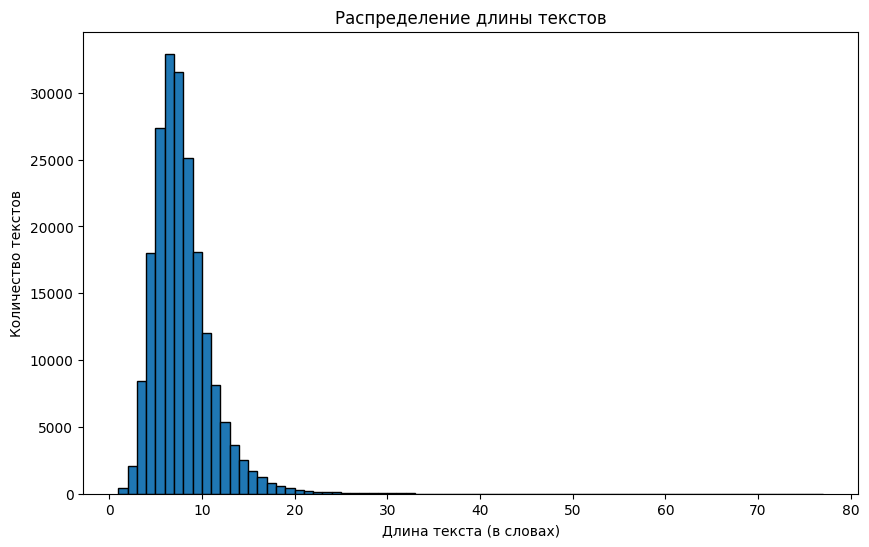

99%-й порог длины текста: 18.0 слов


In [36]:
# Построение гистограммы распределения длины текстов
plt.figure(figsize=(10, 6))
plt.hist([len(desc.split()) for desc in descriptions], bins=range(1, maxSequenceLength + 1), edgecolor='black')
plt.title('Распределение длины текстов')
plt.xlabel('Длина текста (в словах)')
plt.ylabel('Количество текстов')
plt.show()
print(f'99%-й порог длины текста: {np.percentile([len(desc.split()) for desc in descriptions], 99)} слов')

In [17]:
# Обрезка строк до n слов
n = 20
descriptions_trimmed = []
for desc in descriptions:
    words = desc.split()
    # Если в строке больше 63 слов, обрезаем до 63 слов
    descriptions_trimmed.append(' '.join(words[:n]) if len(words) > n else desc)
descriptions = descriptions_trimmed.copy()
del descriptions_trimmed
descriptions = pd.Series(descriptions)

In [ ]:
pip install --upgrade numpy

In [ ]:
pip install tensorflow

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

# Параметры токенизации и последовательностей
max_words = 10000  # Максимальное количество слов в словаре
max_sequence_length = 50  # Максимальная длина последовательности

# Инициализация и обучение токенизатора
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['title'])

# Токенизация текстов
sequences = tokenizer.texts_to_sequences(df['title'])

# Ограничение длины последовательностей
data_padded = pad_sequences(sequences, maxlen=max_sequence_length)

# Преобразование category_code в one-hot векторы
labels = to_categorical(df['category_code'])

# Проверка размеров преобразованных данных
data_padded.shape, labels.shape

((201970, 50), (201970, 228))

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(data_padded, labels, test_size=0.2, random_state=42)

# Создание модели
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_sequence_length))
# model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))  # Изменено здесь
model.add(LSTM(512, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(228, activation='softmax'))  # 228 - количество категорий

# Компиляция модели
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Обучение модели
model.fit(X_train, y_train, batch_size=128, epochs=3, validation_split=0.1)

# Оценка модели
loss, accuracy = model.evaluate(X_test, y_test)
print("Точность на тестовых данных: {:.2f}%".format(accuracy * 100))

Epoch 1/3
1137/1137 [==============================] - 2620s 2s/step - loss: 2.2952 - accuracy: 0.4537 - val_loss: 1.4375 - val_accuracy: 0.6075
Epoch 2/3
1137/1137 [==============================] - 2656s 2s/step - loss: 1.2388 - accuracy: 0.6478 - val_loss: 1.2346 - val_accuracy: 0.6539
Epoch 3/3
1263/1263 [==============================] - 291s 230ms/step - loss: 1.1496 - accuracy: 0.6689
Точность на тестовых данных: 66.89%


In [44]:
# Оценка модели
loss, accuracy = model.evaluate(X_test, y_test)
print("Точность на тестовых данных: {:.2f}%".format(accuracy * 100))

1263/1263 [==============================] - 333s 263ms/step - loss: 1.1192 - accuracy: 0.6891
Точность на тестовых данных: 68.91%


In [29]:
df['theme'].value_counts() #возвращает количество каждого уникального значения в столбце 'theme' и показывает, сколько раз каждое из них встречается в данных

Содержание придомовых территорий, дворов / Уборка зимняя                 11916
Благоустройство вылетных магистралей, улиц и общественных пространств     9845
Содержание МКД / Содержание и текущий ремонт дома                         8285
Состояние воздуха / Неприятные запахи                                     8185
Работа управляющей компании МКД                                           5981
                                                                         ...  
Ремонт и помывка памятников                                                100
Содержание фонтанов, тоннелей, мостов, переходов / Освещение               100
Содержание, устройство, покос, понижение газонов / Понижение газона        100
Политическая ситуация / Шиес; Михали и пр.                                  12
Политическая ситуация / Радон                                                3
Name: theme, Length: 227, dtype: int64

In [30]:
# оценивает доминирующие темы в заданных периодах времени, используя различные длины периодов

total_counts = df['theme'].value_counts() #содержит общее количество уникальных значений в столбце 'theme'

# Функция для создания списка месяцев заданной длины
def get_month_period(start_month, length):
    return [(start_month + i - 1) % 12 + 1 for i in range(length)]

# Функция для создания инвертированного списка месяцев
def get_inverted_period(period):
    return [month % 12 + 1 for month in range(period[0] + len(period) - 1, period[0] + 11)]

def count_dominant_themes(df, months):
    df['is_in_period'] = df['date'].dt.month.isin(months)
    period_counts = df[df['is_in_period']]['theme'].value_counts()
    period_percentage = (period_counts / total_counts) * 100
    dominant_themes = period_percentage[period_percentage >= 95]
    return dominant_themes[dominant_themes.index.isin(total_counts[total_counts > 20].index)].index.tolist()

# Перебор всех возможных длин периодов
for length in range(1, 7):
    print(f"Длина периода: {length} месяц(ев)")

    # Перебор всех возможных начальных месяцев
    for start_month in range(1, 13):
        months = get_month_period(start_month, length)
        inverted_months = get_inverted_period(months)

        # Подсчет количества доминирующих тем для каждого периода
        dominant_themes = count_dominant_themes(df, months)
        inverted_dominant_themes = count_dominant_themes(df, inverted_months)

        # Вывод результатов
        print(f"{months} -> {len(dominant_themes)}")
        print(f"{' ' * (len(str(months)) + 4)}{len(inverted_dominant_themes)} <- {inverted_months}")

    print("---------------")

Длина периода: 1 месяц(ев)
[1] -> 0
       68 <- [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[2] -> 0
       58 <- [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1]
[3] -> 0
       54 <- [4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
[4] -> 0
       34 <- [5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3]
[5] -> 0
       36 <- [6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4]
[6] -> 0
       28 <- [7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5]
[7] -> 0
       18 <- [8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6]
[8] -> 0
       16 <- [9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7]
[9] -> 0
       18 <- [10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8]
[10] -> 0
        23 <- [11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[11] -> 0
        18 <- [12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[12] -> 0
        54 <- [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
---------------
Длина периода: 2 месяц(ев)
[1, 2] -> 0
          32 <- [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[2, 3] -> 0
          26 <- [4, 5, 6, 7, 8, 9, 10, 11, 12, 1]
[3, 4] -> 0
          8 <- [5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
[4, 5] -> 0
          8 <- [6, 7, 

In [31]:
# Создание функций для генерации периодов и подсчета количества тем

def calculate_max_function(len1, len2):
    return len1 + len2 - abs(len1 - len2)

# Словарь для хранения результатов
max_function_results = {}

# Перебор всех возможных длин периодов
for length in range(1, 12):
    # Перебор всех возможных начальных месяцев
    for start_month in range(1, 13):
        months = get_month_period(start_month, length)
        inverted_months = get_inverted_period(months)

        # Подсчет количества доминирующих тем для каждого периода
        len1 = count_dominant_themes(df, months)
        len2 = count_dominant_themes(df, inverted_months)

        # Вычисляем значение функции максимизации для текущего периода
        max_value = calculate_max_function(len1, len2)

        # Сохраняем результат в словаре
        max_function_results[(tuple(months), tuple(inverted_months))] = max_value

# Находим периоды с максимальным значением функции максимизации
max_value = max(max_function_results.values())
max_periods = [period for period, value in max_function_results.items() if value == max_value]

# Выводим периоды и их максимальные значения
max_periods, max_value

TypeError: ignored

In [32]:
import pandas as pd

# Преобразование 'data' в формат даты
# df['date2'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

months = [4, 5, 6, 7, 8, 9, 10]

# Определение летних месяцев
df['period'] = df['date'].dt.month.isin(months)
# df['period'] = df['date'].dt.month.isin(get_inverted_period(months))

# Подсчет общего количества записей для каждой темы
total_counts = df['theme'].value_counts()

# Подсчет количества летних записей для каждой темы
summer_counts = df[df['period']]['theme'].value_counts()

# Процент летних записей от общего числа записей для каждой темы
summer_percentage = (summer_counts / total_counts) * 100

# Фильтрация тем, где процент летних записей >= 95%
summer_dominant_themes = summer_percentage[summer_percentage <= 10]
summer_dominant_themes = summer_dominant_themes[summer_dominant_themes.index.isin(total_counts[total_counts > 20].index)].index.tolist()

print(summer_dominant_themes)

['Антропогенные ЧС / Падение снега и сосулек', 'Водоотведение / Плановое техобслуживание и профилактика', 'Вывоз отходов МГУ', 'Вынос и реконструкция сетей газоснабжения низкого давления', 'Демонтаж, ремонт и установка декоративного наружного освещения / Демонтаж иллюминации и праздничного светового оформления', 'Демонтаж, ремонт и установка декоративного наружного освещения / Демонтаж ландшафтного освещения', 'Демонтаж, ремонт и установка декоративного наружного освещения / Ремонт иллюминации и праздничного светового оформления', 'Демонтаж, ремонт и установка декоративного наружного освещения / Установка иллюминации и праздничного светового оформления', 'Дорожная разметка / Временная разметка', 'Животные и птицы / Восстановление популяции', 'Общая критика мусорной реформы', 'Озера /  Биоразнообразие озера', 'Озера / Капитальный ремонт озер, восстановление', 'ПГМ-обработка тоннелей, мостов, переходов', 'Платежи, взносы и субсидии / Субсидии на платежи ЖКХ', 'Природные ЧС / Снегопады и 

In [35]:
# Выделение месяца
df['month'] = df['date'].dt.month

month = 6
# Фильтрация по теме и месяцу
specific_theme = 'Содержание, устройство, покос, понижение газонов / Покос газона'
june_records = df[(df['theme'] == specific_theme) & (df['month'] == month)]

# Подсчет количества записей
count = june_records.shape[0]

print(f"Количество встречаний темы в июне: {count}")

Количество встречаний темы в июне: 490


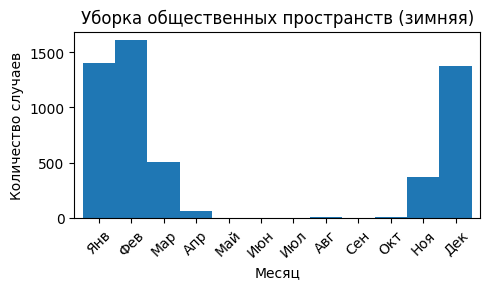

In [36]:
# Фильтрация данных по заданной теме
theme = 'Уборка общественных пространств (зимняя)'
temp_df = df[df['theme'] == theme].copy()

# Подсчет количества записей по месяцам
df['month'] = df['date'].dt.month
monthly_counts = temp_df['month'].value_counts().sort_index()

# Убедимся, что индекс содержит все месяцы
monthly_counts = monthly_counts.reindex(range(1, 13), fill_value=0)

# Создание графика
plt.figure(figsize=(5, 3))
monthly_counts.plot(kind='bar', width=1) # Установите ширину меньше, чтобы столбцы не слипались
plt.title(theme)
plt.xlabel('Месяц')
plt.ylabel('Количество случаев')
plt.xticks(ticks=range(12), labels=['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'], rotation=45)
plt.tight_layout() # Это позволит лучше уместить подписи осей
plt.show()
del temp_df, monthly_counts

In [37]:
df

,date,time,theme,title,post,title_original,post_original,category_code,is_in_period,period,month
0,2021-07-25,NaN,Нелегальные свалки,парк пойма река лесной массив обнаружить масси...,наш подписчик писать граница парк пойма река п...,Награнице парка в пойме реки Городни в лесном...,"Наш подписчик Денис пишет, что на границе парк...",77,True,True,7.0
1,2021-08-05,17:49:38,"Содержание придомовых территорий, дворов / Дет...",критика адрес руководитель гбу жилищникнуть ра...,директор жилищникнуть район переложить ответст...,"Критика в адрес руководителя ГБУ ""Жилищник"" ра...",Директор Жилищника района Хорошёво-Мнёвники Но...,15,True,True,8.0
2,2021-10-12,04:17:26,Состояние воздуха / Неприятные запахи,неудовлетворительный качество воздух район улица,наталья спасибо большой написать это ужас улиц...,Жалоба на неудовлетворительное качество возду...,"Наталья, спасибо большое! Сейчас напишем.Да, э...",34,True,True,10.0
3,2022-04-12,14:32:59,Ремонт дорог / Плохое состояние покрытия и ямо...,требоваться ремонт асфальтовый покрытие улица,показывать провал сделать это пока свой колесо...,Требуется ремонт асфальтового покрытия на ул. ...,[id277681146|Стас Игнатов] показывает провал н...,10,True,True,4.0
4,2022-03-17,20:38:10,Состояние воздуха / Неприятные запахи,евгений направить запрос прокуратура проверка ...,установить свой обращение неравнодушный житель...,Евгений Ступин направил запрос в Роспотребнадз...,Как установили своими обращениями неравнодушны...,34,True,False,3.0
...,...,...,...,...,...,...,...,...,...,...,...
201965,2021-11-19,NaN,Теплоснабжение (центральное отопление) / Несоо...,житель проживать адрес дом пожаловаться перебо...,добый вечер весь участник реновация новостройк...,Житель проживающий по адресу 15я Парковая д. 2...,Добого вечера всем участникам и Сергей Семёнов...,171,True,False,11.0
201966,2021-06-11,16:06:45,"Содержание придомовых территорий, дворов / Дет...",житель район просить построить новый детский п...,просить помочь вернуть детский площадка назад ...,Житель района Строгино просит построить новую ...,[id2704292|Костик Романов] просить помочь верн...,15,True,True,6.0
201967,2022-09-01,09:32:32,"Посадка, уход, пересадка зеленых и цветочных н...",жалоба неудовлетворительный уход зелёный насаж...,активист продолжать путешествие наш улица наш ...,Жалоба на неудовлетворительный уход за зеленым...,Активисты Басманного продолжают путешествие по...,125,True,True,9.0
201968,2021-08-21,NaN,Капитальный ремонт МКД / Ремонт подъезда и вхо...,житель недовольный качество капитальный ремонт...,фото состояние лестница текущий момент стать п...,Житель недоволен качеством капитального ремонт...,на фото - состояние лестницы на текущий момент...,57,True,True,8.0


In [52]:
!pip install tensorflow

In [ ]:
!pip install keras==2.3.1

In [54]:
from keras.utils import to_categorical

Epoch 1/15
1136/1137 [============================>.] - ETA: 0s - loss: 3.1189 - accuracy: 0.2986
Epoch 1: val_accuracy improved from -inf to 0.51912, saving model to models/GRU/model.h5
1137/1137 [==============================] - 224s 180ms/step - loss: 3.1188 - accuracy: 0.2987 - val_loss: 1.9432 - val_accuracy: 0.5191
Epoch 2/15
   1/1137 [..............................] - ETA: 2:23 - loss: 2.4400 - accuracy: 0.4531

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


1137/1137 [==============================] - ETA: 0s - loss: 1.8838 - accuracy: 0.5266
Epoch 2: val_accuracy improved from 0.51912 to 0.59611, saving model to models/GRU/model.h5
1137/1137 [==============================] - 213s 188ms/step - loss: 1.8838 - accuracy: 0.5266 - val_loss: 1.5516 - val_accuracy: 0.5961
Epoch 3/15
1136/1137 [============================>.] - ETA: 0s - loss: 1.6336 - accuracy: 0.5712
Epoch 3: val_accuracy improved from 0.59611 to 0.62334, saving model to models/GRU/model.h5
1137/1137 [==============================] - 189s 167ms/step - loss: 1.6335 - accuracy: 0.5713 - val_loss: 1.4203 - val_accuracy: 0.6233
Epoch 4/15
1137/1137 [==============================] - ETA: 0s - loss: 1.4882 - accuracy: 0.6006
Epoch 4: val_accuracy improved from 0.62334 to 0.63473, saving model to models/GRU/model.h5
1137/1137 [==============================] - 187s 164ms/step - loss: 1.4882 - accuracy: 0.6006 - val_loss: 1.3564 - val_accuracy: 0.6347
Epoch 5/15
1136/1137 [========

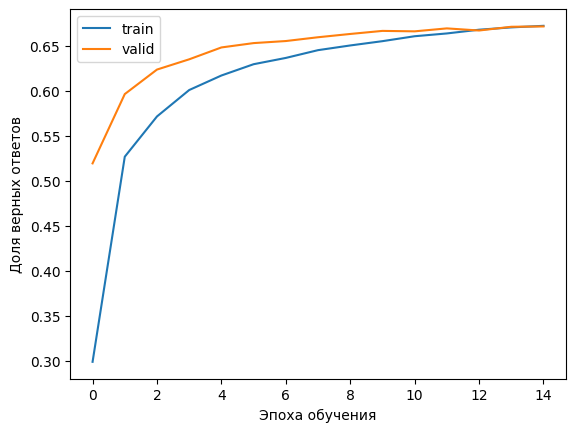

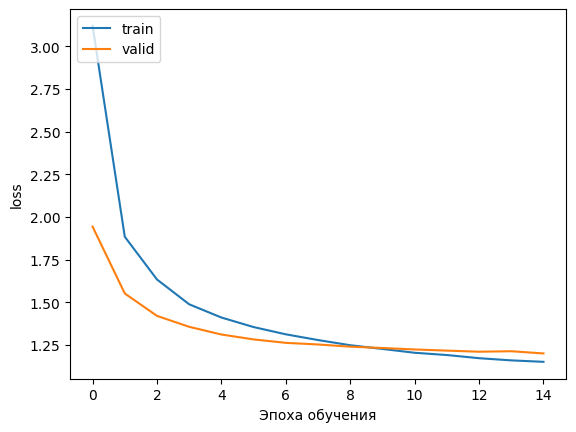

In [56]:
import pandas as pd
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, GRU
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical

import matplotlib.pyplot as plt

# Разделение данных
x_train, x_test, y_train, y_test = train_test_split(data_padded, labels, test_size=0.2, random_state=42)

# Сеть GRU ######################################################
model = Sequential()
num_words = 10000
max_sequence_length = 50
nb_classes = 228
model.add(Embedding(num_words, 64, input_length=max_sequence_length))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_save_path = 'models/GRU/model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

history = model.fit(x_train,
                    y_train,
                    epochs=15,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[checkpoint_callback])

# Оценка модели на тестовых данных
score = model.evaluate(x_test, y_test, batch_size=128, verbose=1)

print()
print("Оценка теста: {}".format(score[0]))
print("Оценка точности модели: {}".format(score[1]))

# График точности
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'valid'], loc='upper left')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.show()

# График потерь
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('Эпоха обучения')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [60]:
history = model.fit(x_train,
                    y_train,
                    epochs=7,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[checkpoint_callback])

# Оценка модели на тестовых данных
score = model.evaluate(x_test, y_test, batch_size=128, verbose=1)

print()
print("Оценка теста: {}".format(score[0]))
print("Оценка точности модели: {}".format(score[1]))

# График точности
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'valid'], loc='upper left')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.show()

# График потерь
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('Эпоха обучения')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

Epoch 1/7
1137/1137 [==============================] - ETA: 0s - loss: 1.1367 - accuracy: 0.6761
Epoch 1: val_accuracy improved from 0.67125 to 0.67397, saving model to models/GRU/model.h5
1137/1137 [==============================] - 223s 196ms/step - loss: 1.1367 - accuracy: 0.6761 - val_loss: 1.2010 - val_accuracy: 0.6740
Epoch 2/7
   1/1137 [..............................] - ETA: 2:38 - loss: 1.0509 - accuracy: 0.7031

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


1137/1137 [==============================] - ETA: 0s - loss: 1.1281 - accuracy: 0.6776
Epoch 2: val_accuracy did not improve from 0.67397
1137/1137 [==============================] - 215s 189ms/step - loss: 1.1281 - accuracy: 0.6776 - val_loss: 1.1957 - val_accuracy: 0.6727
Epoch 3/7
 759/1137 [===================>..........] - ETA: 1:03 - loss: 1.1097 - accuracy: 0.6816

KeyboardInterrupt: ignored

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


# Наивный Байесовский классификатор ##############################
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
               ])
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print(X_test[0])
print(y_test[0])
print(y_pred[0])

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

NameError: ignored

In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(data_padded, labels, test_size=0.2, random_state=42)
# Преобразование в numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)

# Наивный Байесовский классификатор ##############################
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
               ])
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print(X_test[0])
print(y_test[0])
print(y_pred[0])

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

AttributeError: ignored

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(data_padded, labels, test_size=0.2, random_state=42)

# Создание модели
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_sequence_length))
# model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))  # Изменено здесь
model.add(LSTM(512, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(227, activation='softmax'))  # 227 - количество категорий

# Компиляция модели
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Обучение модели
model.fit(X_train, y_train, batch_size=128, epochs=2, validation_split=0.1)

# Оценка модели
loss, accuracy = model.evaluate(X_test, y_test)
print("Точность на тестовых данных: {:.2f}%".format(accuracy * 100))

Epoch 1/2


1153/1153 [==============================] - 2622s 2s/step - loss: 1.9864 - accuracy: 0.5282 - val_loss: 1.2164 - val_accuracy: 0.6685
Epoch 2/2
1282/1282 [==============================] - 148s 115ms/step - loss: 1.0373 - accuracy: 0.7059
Точность на тестовых данных: 70.59%


In [ ]:
total_counts = df['theme'].value_counts()

# Функция для создания списка месяцев заданной длины
def get_month_period(start_month, length):
    return [(start_month + i - 1) % 12 + 1 for i in range(length)]

# Функция для создания инвертированного списка месяцев
def get_inverted_period(period):
    return [month % 12 + 1 for month in range(period[0] + len(period) - 1, period[0] + 11)]

# Функция для подсчета количества доминирующих тем
# def count_dominant_themes(df, months):
#     df['is_in_period'] = df['date'].dt.month.isin(months)
#     period_counts = df[df['is_in_period']]['theme'].value_counts()
#     period_percentage = (period_counts / total_counts) * 100
#     return period_percentage[period_percentage >= 95].index.tolist()

def count_dominant_themes(df, months):
    df['is_in_period'] = df['date'].dt.month.isin(months)
    period_counts = df[df['is_in_period']]['theme'].value_counts()
    period_percentage = (period_counts / total_counts) * 100
    dominant_themes = period_percentage[period_percentage >= 95]
    return dominant_themes[dominant_themes.index.isin(total_counts[total_counts > 20].index)].index.tolist()

# Перебор всех возможных длин периодов
for length in range(1, 7):
    print(f"Длина периода: {length} месяц(ев)")

    # Перебор всех возможных начальных месяцев
    for start_month in range(1, 13):
        months = get_month_period(start_month, length)
        inverted_months = get_inverted_period(months)

        # Подсчет количества доминирующих тем для каждого периода
        dominant_themes = count_dominant_themes(df, months)
        inverted_dominant_themes = count_dominant_themes(df, inverted_months)

        # Вывод результатов
        print(f"{months} -> {len(dominant_themes)}")
        print(f"{' ' * (len(str(months)) + 4)}{len(inverted_dominant_themes)} <- {inverted_months}")

    print("---------------")

Длина периода: 1 месяц(ев)
[1] -> 0
       89 <- [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[2] -> 0
       73 <- [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1]
[3] -> 0
       75 <- [4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
[4] -> 0
       47 <- [5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3]
[5] -> 0
       54 <- [6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4]
[6] -> 0
       39 <- [7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5]
[7] -> 0
       38 <- [8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6]
[8] -> 0
       46 <- [9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7]
[9] -> 0
       56 <- [10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8]
[10] -> 0
        59 <- [11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[11] -> 0
        45 <- [12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[12] -> 0
        70 <- [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
---------------
Длина периода: 2 месяц(ев)
[1, 2] -> 0
          40 <- [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[2, 3] -> 0
          34 <- [4, 5, 6, 7, 8, 9, 10, 11, 12, 1]
[3, 4] -> 0
          21 <- [5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
[4, 5] -> 0
          14 <- [6, 7

In [ ]:
df

,date,time,theme,title,post,title_original,post_original,category_code,is_in_period
0,2021-04-22,14:41:09,Содержание МКД / Содержание и текущий ремонт дома,просьба восстановить работоспособность светово...,народ приложение город присоединяться заявка ч...,Просьба восстановить работоспособность светово...,"Народ, кто с Мск и есть приложение ""Наш город""...",18,False
1,2023-07-08,21:29:54,"Содержание придомовых территорий, дворов / Вн...",житель обращать внимание неудовлетворительный ...,новый тротуар улица,Жители обращают внимание на неудовлетворительн...,Новый тротуар по улице Цетральная 9П. Первомай...,25,True
2,2021-10-01,09:08:31,"Благоустройство вылетных магистралей, улиц и о...",критика повод качество благоустройство тротуар...,извинить присылать фото новый заузить дорога п...,Критика по поводу качества благоустройства тро...,Извините что опять присылаю фото новой зауженн...,13,True
3,2023-01-30,14:55:57,Содержание МКД / Содержание и текущий ремонт дома,житель указывать отвалиться штукатурка фасад д...,произойти фасад такой вид жилищникнуть обратит...,Житель указывает на отвалившуюся штукатурку с ...,"Что произошло с фасадом на Авиационной, 68? По...",18,False
4,2023-07-19,18:17:30,"Благоустройство вылетных магистралей, улиц и о...",житель интересоваться начать обновление двор у...,просить разобраться двор обновление должный на...,"Житель интересуется, когда начнут обновление д...",[id692894443|Сергей Кобра] просит разобраться ...,13,True
...,...,...,...,...,...,...,...,...,...
204956,NaT,NaN,Сопряженные земляные работы,жалоба земельный работа улица дом проводить ра...,раскопка дом перекрыть проход сколько издевать...,Жалоба на земельные работы на улице 2-я Остан...,Раскопки у дома 8 по 2-й Останкинской уже пере...,66,False
204957,2021-05-23,19:18:42,Контейнерные площадки,вместо спортивный площадка поставить открыт ко...,вместо спортивный площадка поставить огромный ...,Вместо спортивной площадки поставили открыте к...,А у нас вместо спортивной площадки поставили о...,206,False
204958,2020-10-12,NaN,"Посадка, уход, пересадка зеленых и цветочных н...",пересечение улица улица сломать клумба жилищни...,отремонтировать мастер средний клумба собрать ...,На пересечении ул. Новокосинская и ул. Суздаль...,Отремонтировали мастера из средней Азии клумбу...,117,True
204959,2021-07-15,NaN,Техногенные ЧС / Прорыв систем водоснабжения,прорыв коммуникация водоснабжение улица,писать дом прорвать течь вода,Прорыв коммуникаций водоснабжения на ул. Новат...,"[id39081581|Анна Ниволина] пишет, что за домом...",42,True


In [ ]:
import pandas as pd

# Преобразование 'data' в формат даты
# df['date2'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

months = [4, 5, 6, 7, 8, 9, 10]

# Определение летних месяцев
df['period'] = df['date'].dt.month.isin(months)
# df['period'] = df['date'].dt.month.isin(get_inverted_period(months))

# Подсчет общего количества записей для каждой темы
total_counts = df['theme'].value_counts()

# Подсчет количества летних записей для каждой темы
summer_counts = df[df['period']]['theme'].value_counts()

# Процент летних записей от общего числа записей для каждой темы
summer_percentage = (summer_counts / total_counts) * 100

# Фильтрация тем, где процент летних записей >= 95%
summer_dominant_themes = summer_percentage[summer_percentage <= 10]
summer_dominant_themes = summer_dominant_themes[summer_dominant_themes.index.isin(total_counts[total_counts > 20].index)].index.tolist()

print(summer_dominant_themes)

['Антропогенные ЧС / Падение снега и сосулек', 'Снег и снегосплавные пункты', 'Содержание МКД / Содержание и уборка кровли', 'Содержание дорог / ПГМ-обработка', 'Содержание дорог / Уборка (зимняя)', 'Содержание придомовых территорий, дворов / ПГМ-обработка', 'Содержание придомовых территорий, дворов / Уборка зимняя', 'Уборка общественных пространств (ПГМ)', 'Уборка общественных пространств (зимняя)']


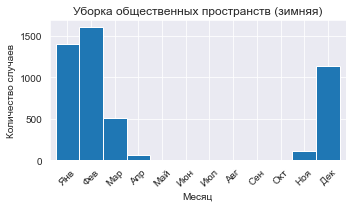

In [ ]:
# Фильтрация данных по заданной теме
theme = 'Уборка общественных пространств (зимняя)'
temp_df = df[df['theme'] == theme].copy()

# Подсчет количества записей по месяцам
df['month'] = df['date'].dt.month
monthly_counts = temp_df['month'].value_counts().sort_index()

# Убедимся, что индекс содержит все месяцы
monthly_counts = monthly_counts.reindex(range(1, 13), fill_value=0)

# Создание графика
plt.figure(figsize=(5, 3))
monthly_counts.plot(kind='bar', width=1) # Установите ширину меньше, чтобы столбцы не слипались
plt.title(theme)
plt.xlabel('Месяц')
plt.ylabel('Количество случаев')
plt.xticks(ticks=range(12), labels=['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'], rotation=45)
plt.tight_layout() # Это позволит лучше уместить подписи осей
plt.show()
del temp_df, monthly_counts

In [ ]:
import pandas as pd

# Преобразование 'data' в формат даты
df['date2'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Определение летних месяцев
df['is_summer'] = df['date2'].dt.month.isin([4, 5, 6, 7, 8, 9])
# df['is_summer'] = df['date2'].dt.month.isin([1, 2, 3, 10, 11, 12])

# Подсчет общего количества записей для каждой темы
total_counts = df['theme'].value_counts()

# Подсчет количества летних записей для каждой темы
summer_counts = df[df['is_summer']]['theme'].value_counts()

# Процент летних записей от общего числа записей для каждой темы
summer_percentage = (summer_counts / total_counts) * 100

# Фильтрация тем, где процент летних записей >= 90%
summer_dominant_themes = summer_percentage[summer_percentage >= 90].index.tolist()

print(summer_dominant_themes)

['Антропогенные ЧС / Пропавшие на воде', 'Политическая ситуация / Выборы', 'Природные ЧС / Удар молнией', 'Растения / Борщевик', 'Растения / Восстановление разнообразия', 'Растения / Краснокнижные растения', 'Содержание, устройство, покос, понижение газонов / Покос газона', 'Содержание, устройство, покос, понижение газонов / Понижение газона']


In [ ]:
# Выделение месяца
df['month'] = df['date'].dt.month

month = 6
# Фильтрация по теме и месяцу
specific_theme = 'Содержание, устройство, покос, понижение газонов / Покос газона'
june_records = df[(df['theme'] == specific_theme) & (df['month'] == month)]

# Подсчет количества записей
count = june_records.shape[0]

print(f"Количество встречаний темы в июне: {count}")

Количество встречаний темы в июне: 490


In [ ]:
df

,date,time,theme,title,post,title_original,post_original,category_code,is_in_period,period,date2,is_summer,month
0,2021-04-22,14:41:09,Содержание МКД / Содержание и текущий ремонт дома,просьба восстановить работоспособность светово...,народ приложение город присоединяться заявка ч...,Просьба восстановить работоспособность светово...,"Народ, кто с Мск и есть приложение ""Наш город""...",18,False,True,2021-04-22,True,4.0
1,2023-07-08,21:29:54,"Содержание придомовых территорий, дворов / Вн...",житель обращать внимание неудовлетворительный ...,новый тротуар улица,Жители обращают внимание на неудовлетворительн...,Новый тротуар по улице Цетральная 9П. Первомай...,25,True,True,2023-07-08,True,7.0
2,2021-10-01,09:08:31,"Благоустройство вылетных магистралей, улиц и о...",критика повод качество благоустройство тротуар...,извинить присылать фото новый заузить дорога п...,Критика по поводу качества благоустройства тро...,Извините что опять присылаю фото новой зауженн...,13,True,True,2021-10-01,False,10.0
3,2023-01-30,14:55:57,Содержание МКД / Содержание и текущий ремонт дома,житель указывать отвалиться штукатурка фасад д...,произойти фасад такой вид жилищникнуть обратит...,Житель указывает на отвалившуюся штукатурку с ...,"Что произошло с фасадом на Авиационной, 68? По...",18,False,False,2023-01-30,False,1.0
4,2023-07-19,18:17:30,"Благоустройство вылетных магистралей, улиц и о...",житель интересоваться начать обновление двор у...,просить разобраться двор обновление должный на...,"Житель интересуется, когда начнут обновление д...",[id692894443|Сергей Кобра] просит разобраться ...,13,True,True,2023-07-19,True,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204956,NaT,NaN,Сопряженные земляные работы,жалоба земельный работа улица дом проводить ра...,раскопка дом перекрыть проход сколько издевать...,Жалоба на земельные работы на улице 2-я Остан...,Раскопки у дома 8 по 2-й Останкинской уже пере...,66,False,False,NaT,False,NaN
204957,2021-05-23,19:18:42,Контейнерные площадки,вместо спортивный площадка поставить открыт ко...,вместо спортивный площадка поставить огромный ...,Вместо спортивной площадки поставили открыте к...,А у нас вместо спортивной площадки поставили о...,206,False,True,2021-05-23,True,5.0
204958,2020-10-12,NaN,"Посадка, уход, пересадка зеленых и цветочных н...",пересечение улица улица сломать клумба жилищни...,отремонтировать мастер средний клумба собрать ...,На пересечении ул. Новокосинская и ул. Суздаль...,Отремонтировали мастера из средней Азии клумбу...,117,True,True,2020-10-12,False,10.0
204959,2021-07-15,NaN,Техногенные ЧС / Прорыв систем водоснабжения,прорыв коммуникация водоснабжение улица,писать дом прорвать течь вода,Прорыв коммуникаций водоснабжения на ул. Новат...,"[id39081581|Анна Ниволина] пишет, что за домом...",42,True,True,2021-07-15,True,7.0


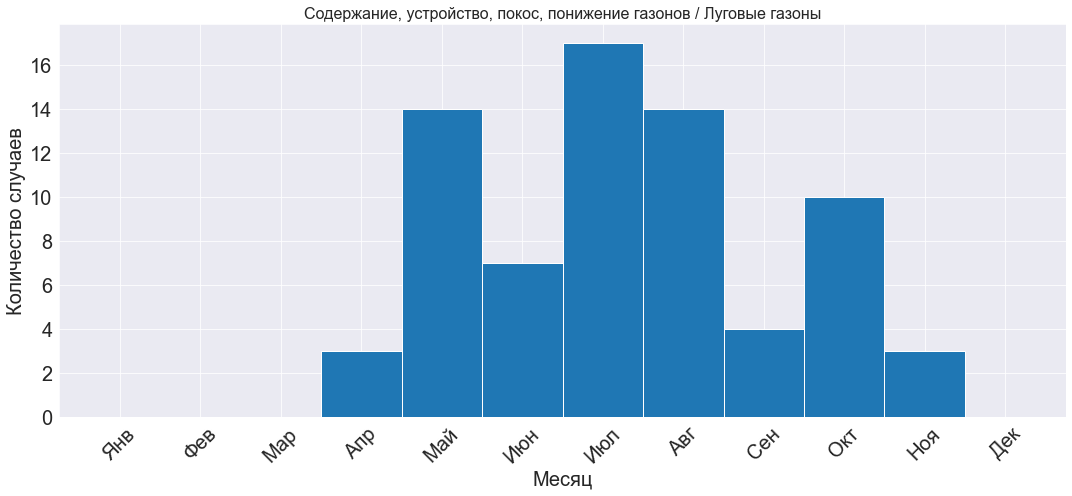

In [ ]:
# Фильтрация данных по заданной теме
theme = 'Содержание, устройство, покос, понижение газонов / Луговые газоны'
temp_df = df[df['theme'] == theme].copy()

# Подсчет количества записей по месяцам
monthly_counts = temp_df['month'].value_counts().sort_index()

# Убедимся, что индекс содержит все месяцы
monthly_counts = monthly_counts.reindex(range(1, 13), fill_value=0)

# Создание графика
plt.figure(figsize=(15, 7))
monthly_counts.plot(kind='bar', width=1) # Установите ширину меньше, чтобы столбцы не слипались
plt.title(theme, fontsize=16) # Увеличение размера заголовка
plt.xlabel('Месяц', fontsize=20) # Увеличение размера подписи оси X
plt.ylabel('Количество случаев', fontsize=20) # Увеличение размера подписи оси Y
plt.xticks(ticks=range(12), labels=['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'], rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout() # Это позволит лучше уместить подписи осей
plt.show()
del temp_df, monthly_counts

In [ ]:
df

,date,time,theme,title,post,title_original,post_original,category_code,is_in_period,period,month,date2,is_summer
0,2023-07-17,10:26:28,"Посадка, уход, пересадка зеленых и цветочных н...",жалоба отсутствие уход вырубка зелёный насажде...,быть голосовать против мэр администрация посел...,Жалоба на отсутствие ухода и вырубку зеленых н...,Буду голосовать против мэра. Потому что его ад...,125,True,True,7.0,2023-07-17,True
1,2021-09-08,NaN,Антропогенные ЧС / Крупные ДТП,шоссе грузовик попасть дтп загореться,киевский шоссе,На Киевском шоссе грузовик попал в ДТП и загор...,Киевское шоссе@dtp777bot,84,True,True,9.0,2021-09-08,True
2,2022-01-11,NaN,Уборка общественных пространств (зимняя),житель негодовать связь отсутствие уборка снег...,дубль сколько человек должный упасть очистить ...,Житель негодует в связи с отсутствием уборки с...,Дубль lllПортал «Москва Наш Город» сколько че...,191,False,False,1.0,2022-01-11,False
3,2022-11-19,00:15:05,Благоустройство ООПТ: общее и прочее,депутат депутат муниципальный округ город сооб...,мундепыкрылатский парксказка мосприрода дпиоос...,Депутат в Совет депутатов муниципального округ...,#мундепыКрылатского #паркСказка #мосприрода #д...,113,True,False,11.0,2022-11-19,False
4,2022-12-13,11:20:26,Содержание дорог / Уборка (зимняя),видеоролик,,Видеоролик в,NaN,116,True,False,12.0,2022-12-13,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204956,2020-10-11,NaN,Состояние воздуха / Показатели загрязнения воз...,агрегировать показание датчик государственный ...,комментарий пост работать специалист который м...,АirVisual агрегирует показания датчиков госуда...,Комментарий к посту: Наталья Ярыгина\nот 11.10...,52,True,True,10.0,2020-10-11,False
204957,2021-02-24,21:01:43,"Содержание придомовых территорий, дворов / Убо...",жалоба неубранный куча снег дом проезд,изменение февраль,Жалоба на неубранную кучу снега у дома на Марф...,@DGKH_mos_ru\n @MosSobyanin\n без изменений. 2...,159,True,False,2.0,2021-02-24,False
204958,NaT,NaN,"Платежи, взносы и субсидии / Приборы учета",житель пожаловаться компания связь затянуться ...,мосэнергосбыт месяц поменять счётчик сломаться...,Житель пожаловался на компанию Мосэнергосбыт в...,Мосэнергосбыт уже 5 месяцев не может поменять ...,207,False,False,NaN,NaT,False
204959,2022-06-26,14:20:35,Работа управляющей компании МКД,критика адрес гбу жилищникнуть район повод раз...,выборы начаться один зарегистрировать кандидат...,"Критика в адрес ГБУ ""Жилищник"" района Южное Бу...","Выборы еще только начались, но еще нет ни одно...",8,True,True,6.0,2022-06-26,True


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Векторизация текста
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['title'])
y = df['theme']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Создание модели случайного леса
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42, verbose=2)

# Обучение модели
rf_classifier.fit(X_train, y_train)

# Оценка модели
y_pred = rf_classifier.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  7.5min


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.3s


                                                                                                                            precision    recall  f1-score   support

                                                                                                        Адресные указатели       0.85      0.77      0.81        30
                                                                                     Антропогенные ЧС / Зимние виды отдыха       0.65      0.54      0.59        28
                                                                                            Антропогенные ЧС / Крупные ДТП       0.87      0.95      0.91       770
                                                                           Антропогенные ЧС / Несчастные случаи с рабочими       0.94      0.61      0.74        28
                                                                              Антропогенные ЧС / Открытые и сломанные люки       0.89      0.92      0.90       457
               

In [20]:
from joblib import dump

# Предполагаем, что rf_classifier - это ваша обученная модель
# Сохранение модели
dump(rf_classifier, 'random_forest_model_v1.joblib')

['random_forest_model_v1.joblib']

In [ ]:
from joblib import load

# Загрузка модели
rf_classifier = load('random_forest_model_v1.joblib')

MemoryError: Unable to allocate 140. MiB for an array with shape (18388038,) and data type float64

In [ ]:
import pymorphy3
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Инициализация анализатора pymorphy2
morph = pymorphy3.MorphAnalyzer()
russian_stopwords = stopwords.words('russian')

# Функция для лемматизации и удаления стоп-слов
def preprocess_text(text):
    words = word_tokenize(text)
    filtered_lemmatized_text = []
    for word in words:
        if word.lower() not in russian_stopwords:
            parsed_word = morph.parse(word)[0]
            filtered_lemmatized_text.append(parsed_word.normal_form)
    return ' '.join(filtered_lemmatized_text)

# Ваш входной текст
input_text = "Реставрировать подъезд в доме"

# Предобработка текста
processed_text = preprocess_text(input_text)

# Векторизация текста
input_vector = tfidf.transform([processed_text])

# Предсказание с помощью модели
prediction = rf_classifier.predict(input_vector)

# Вывод результата
print("Предсказанная тема:", prediction[0])

Предсказанная тема: Содержание МКД / Содержание и текущий ремонт дома


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


In [ ]:
# Функция для получения предсказаний
def predict_classes(model, vectors):
    predictions = model.predict(vectors)
    return np.argmax(predictions, axis=1)

# Преобразование столбца 'vector' в подходящий формат (если необходимо)
vectors = np.array(df['vector'].tolist())

# Получение предсказаний
predicted_classes = predict_classes(model, vectors)

# Добавление предсказанных классов в датафрейм
df['predicted_class'] = predicted_classes

KeyError: 'vector'

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Предобработка данных
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['title'])
encoder = LabelEncoder()
y = encoder.fit_transform(df['theme'])

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Обучение модели
model = XGBClassifier(eval_metric='mlogloss', early_stopping_rounds=10, verbosity=1)

# Добавление eval_set и early_stopping_rounds
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Оценка модели
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

[0]	validation_0-mlogloss:3.26353
[1]	validation_0-mlogloss:6.69566
[2]	validation_0-mlogloss:6.30171
[3]	validation_0-mlogloss:6.66107
[4]	validation_0-mlogloss:5.71834
[5]	validation_0-mlogloss:6.21382
[6]	validation_0-mlogloss:5.34230
[7]	validation_0-mlogloss:5.69861
[8]	validation_0-mlogloss:4.83395
[9]	validation_0-mlogloss:5.22303
[10]	validation_0-mlogloss:4.47991
Accuracy: 0.6219598468031128


In [ ]:
del model

In [ ]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# MLP
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Предобработка данных
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['title'])
encoder = LabelEncoder()
y = encoder.fit_transform(df['theme'])

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Создание и настройка модели MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(250,), max_iter=3, activation='relu', solver='adam', random_state=42, verbose=True)

# Обучение модели
mlp_model.fit(X_train, y_train)

# Оценка модели
y_pred_mlp = mlp_model.predict(X_test)
print(f"Accuracy of MLP: {accuracy_score(y_test, y_pred_mlp)}")

Iteration 1, loss = 2.01446500
Iteration 2, loss = 0.95372387
Iteration 3, loss = 0.76178757


C:\Users\4793788\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of MLP: 0.7388578537799136


In [ ]:
# MLP
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Предобработка данных
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['title'])
encoder = LabelEncoder()
y = encoder.fit_transform(df['theme'])

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Создание и настройка модели MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(250,), max_iter=1, activation='relu', solver='adam', random_state=42, warm_start=True) # adam sgd lbfgs

# Инициализация списков для сохранения точности
accuracy_train = []
accuracy_test = []

In [ ]:
# Итерационное обучение модели
for i in range(8):
    mlp_model.fit(X_train, y_train)

    # Вычисление точности для тренировочной выборки
    y_pred_train = mlp_model.predict(X_train)
    accuracy_train.append(accuracy_score(y_train, y_pred_train))

    # Вычисление точности для тестовой выборки
    y_pred_test = mlp_model.predict(X_test)
    accuracy_test.append(accuracy_score(y_test, y_pred_test))

    print(f"Iteration {i}, Train accuracy: {accuracy_train[-1]}, Test accuracy: {accuracy_test[-1]}")

C:\Users\4793788\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 0, Train accuracy: 0.7233423594847775, Test accuracy: 0.6973629644085576
Iteration 1, Train accuracy: 0.7694489168618267, Test accuracy: 0.7254897177566901
Iteration 2, Train accuracy: 0.7943196233411397, Test accuracy: 0.7345400434220477
Iteration 3, Train accuracy: 0.8137868364558938, Test accuracy: 0.7416144219744835
Iteration 4, Train accuracy: 0.8292349726775956, Test accuracy: 0.7464689093259825
Iteration 5, Train accuracy: 0.8422497072599532, Test accuracy: 0.7491522942941478
Iteration 6, Train accuracy: 0.8528249414519906, Test accuracy: 0.7518600736711146
Iteration 7, Train accuracy: 0.8622292154566745, Test accuracy: 0.7537384431488303


In [ ]:
# Оценка модели
y_pred_mlp = mlp_model.predict(X_test)
print(f"Accuracy of MLP: {accuracy_score(y_test, y_pred_mlp)}")

Accuracy of MLP: 0.7537384431488303


In [ ]:
from joblib import dump

# Сохранение модели
dump(mlp_model, 'mlp_model_v1.joblib')

['mlp_model_v1.joblib']

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Определение устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('CUDA:', torch.cuda.is_available())

# Класс для обработки текстовых данных
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.X = texts
        self.y = labels

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]
        x = torch.FloatTensor(x.toarray().squeeze(0)).to(device)  # Перемещение на GPU
        y = torch.tensor(self.y[idx], dtype=torch.long).to(device)  # Перемещение на GPU
        return x, y

# Предобработка данных
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['title'])
encoder = LabelEncoder()
y = encoder.fit_transform(df['theme'])

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Создание Datasets и DataLoaders
train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Определение модели
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.35):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

input_size = X_train.shape[1]
hidden_size = 350
num_classes = len(set(y))
model = MLP(input_size, hidden_size, num_classes).to(device) # Перемещение модели на GPU

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Функция для вычисления точности
def calculate_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for texts, labels in data_loader:
            texts = texts.to(device)
            labels = labels.to(device)
            outputs = model(texts.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

CUDA: False


In [ ]:
# Цикл обучения
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for i, (texts, labels) in enumerate(train_loader):
        texts = texts.to(device)
        labels = labels.to(device)
        outputs = model(texts.float())
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_accuracy = calculate_accuracy(model, train_loader, device)
    test_accuracy = calculate_accuracy(model, test_loader, device)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

Epoch [1/10], Loss: 0.7316545248031616, Train Accuracy: 0.7585565476190477, Test Accuracy: 0.7216354011660527
Epoch [2/10], Loss: 1.1207975149154663, Train Accuracy: 0.8144211065573771, Test Accuracy: 0.741931549288903
Epoch [3/10], Loss: 0.5382124185562134, Train Accuracy: 0.8493791471506635, Test Accuracy: 0.7521040177591296
Epoch [4/10], Loss: 0.5922040939331055, Train Accuracy: 0.8731032884465262, Test Accuracy: 0.7597394677139999
Epoch [5/10], Loss: 1.0135726928710938, Train Accuracy: 0.8932352654176424, Test Accuracy: 0.7663747469080087
Epoch [6/10], Loss: 0.43686622381210327, Train Accuracy: 0.905121731069477, Test Accuracy: 0.7680823555241139
Epoch [7/10], Loss: 0.45226454734802246, Train Accuracy: 0.9172704430132709, Test Accuracy: 0.774010196862879
Epoch [8/10], Loss: 0.6617400646209717, Train Accuracy: 0.9240949453551912, Test Accuracy: 0.774205352133291
Epoch [9/10], Loss: 0.45113369822502136, Train Accuracy: 0.9323892466822795, Test Accuracy: 0.777498597321494
Epoch [10/10

In [ ]:
# Итерационное обучение модели
for i in range(2, 5):
    mlp_model.fit(X_train, y_train)

    # Вычисление точности для тренировочной выборки
    y_pred_train = mlp_model.predict(X_train)
    accuracy_train.append(accuracy_score(y_train, y_pred_train))

    # Вычисление точности для тестовой выборки
    y_pred_test = mlp_model.predict(X_test)
    accuracy_test.append(accuracy_score(y_test, y_pred_test))

    print(f"Iteration {i}, Train accuracy: {accuracy_train[-1]}, Test accuracy: {accuracy_test[-1]}")

In [ ]:
del mlp_model

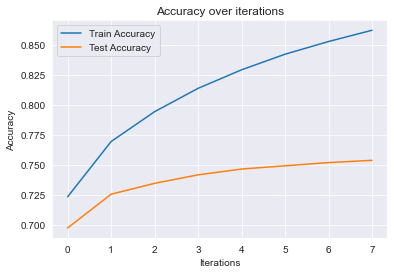

In [ ]:
# Построение графика точности
plt.plot(accuracy_train, label='Train Accuracy')
plt.plot(accuracy_test, label='Test Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy over iterations')
plt.legend()
plt.show()

In [ ]:
from joblib import load

# Загрузка модели
mlp_model1 = load('mlp_model_period1_v1.joblib')
mlp_model2 = load('mlp_model_period2_v1.joblib')

C:\Users\4793788\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\4793788\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
"""# Обучение vectorizer1 на df_period1
vectorizer1 = TfidfVectorizer()
X1 = vectorizer1.fit_transform(df_period1['title'])

# Обучение vectorizer2 на df_period2
vectorizer2 = TfidfVectorizer()
X2 = vectorizer2.fit_transform(df_period2['title'])

# Предсказание темы с использованием соответствующего vectorizer и модели
predictions = []
for i in range(len(df)):
    if df['month'][i] in [4, 5, 6, 7, 8, 9, 10]:
        X_new = vectorizer1.transform([df['title'][i]])  # Применяем vectorizer1
        pred = mlp_model1.predict(X_new)
    else:
        X_new = vectorizer2.transform([df['title'][i]])  # Применяем vectorizer2
        pred = mlp_model2.predict(X_new)

    # Добавляем предсказание в список
    predictions.append(pred[0])

# Преобразование предсказаний обратно в названия тем
predicted_themes = encoder.inverse_transform(predictions)
"""

"# Обучение vectorizer1 на df_period1\nvectorizer1 = TfidfVectorizer()\nX1 = vectorizer1.fit_transform(df_period1['title'])\n\n# Обучение vectorizer2 на df_period2\nvectorizer2 = TfidfVectorizer()\nX2 = vectorizer2.fit_transform(df_period2['title'])\n\n# Предсказание темы с использованием соответствующего vectorizer и модели\npredictions = []\nfor i in range(len(df)):\n    if df['month'][i] in [4, 5, 6, 7, 8, 9, 10]:\n        X_new = vectorizer1.transform([df['title'][i]])  # Применяем vectorizer1\n        pred = mlp_model1.predict(X_new)\n    else:\n        X_new = vectorizer2.transform([df['title'][i]])  # Применяем vectorizer2\n        pred = mlp_model2.predict(X_new)\n\n    # Добавляем предсказание в список\n    predictions.append(pred[0])\n\n# Преобразование предсказаний обратно в названия тем\npredicted_themes = encoder.inverse_transform(predictions)\n"

In [ ]:
"""predictions_combined = pd.Series(index=df_title.index, dtype='int')
predictions_combined[df_title_month.index] = predictions_month
predictions_combined[df_title_other.index] = predictions_other

# Расчет точности
accuracy_overall = accuracy_score(y_true, predictions_combined)
print(f"Overall Accuracy: {accuracy_overall}")"""

'predictions_combined = pd.Series(index=df_title.index, dtype=\'int\')\npredictions_combined[df_title_month.index] = predictions_month\npredictions_combined[df_title_other.index] = predictions_other\n\n# Расчет точности\naccuracy_overall = accuracy_score(y_true, predictions_combined)\nprint(f"Overall Accuracy: {accuracy_overall}")'

In [ ]:
"""
# Предсказание тем для всех данных
y_pred_all = mlp_model.predict(X)

# Преобразование числовых предсказаний в текстовые метки
predicted_themes = encoder.inverse_transform(y_pred_all)

# Добавление предсказанных тем в DataFrame
df['predicted_theme'] = predicted_themes
"""

In [ ]:
df

,date,time,theme,title,post,title_original,post_original,category_code,is_in_period,period,date2,is_summer,month
0,2022-04-21,00:31:06,Работа управляющей компании МКД,сообщаться житель избрать управлять компания г...,сфера жкх захват дом район несмотря житель изб...,Сообщается что жители избрали управляющую комп...,"Сфера ЖКХ захват домов - в Хорошевское районе,...",8,False,True,2022-04-21,True,4.0
1,2022-05-03,11:52:51,Контейнерные площадки,отсутствие вывоз мусор деревня,помойка дом около дикси май май вывозить мусор,Отсутствие вывоза мусора в деревне Шарапово,"Помойка в д. Шарапово около дикси 1 мая, а что...",206,False,True,2022-05-03,True,5.0
2,2023-01-20,13:47:04,Работа управляющей компании МКД,директор гбу жилищникнуть район суд признаться...,директор жилищникнуть суд признаться закрыть п...,"Директор ГБУ ""Жилищника района Хорошево-Мневни...",Директор Жилищника Хорошёво-Мнёвники Ножипов в...,8,False,False,2023-01-20,False,1.0
3,2021-03-03,15:02:36,"Содержание придомовых территорий, дворов / Убо...",сотрудник коммунальный служба скидывать снег к...,мда ушкоммунальщик работать,Сотрудники коммунальных служб скидывают снег с...,Мда ушКоммунальщики работают,159,False,False,2021-03-03,False,3.0
4,2023-03-26,07:21:47,Природные ЧС / Упавшие и поваленные деревья,жалоба нависать дерево,второе такой дерево рисковать упасть рядом ост...,Жалоба на нависающее дерево,А второе такое дерево рискует упасть рядом с о...,3,False,False,2023-03-26,False,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204956,2021-05-27,00:45:11,Состояние воздуха / Неприятные запахи,жалоба неприятный едкий запах улица,сегодня утром около накрыть едкий удушливый хи...,"Жалоба на неприятные, едкие запахи по улице Ро...",Сегодня утром около 4-20 Россошанскую ул накры...,34,False,True,2021-05-27,True,5.0
204957,2021-12-04,NaN,"Содержание, устройство, покос, понижение газон...",жалоба плохой состояние газон улица дом улица дом,газон вдоль железка весь забоочный трава сгнит...,Жалоба на плохое состояние газона от ул. Берза...,Газон от Берзарина 3 до Берзарина 1 вдоль желе...,4,False,False,2021-12-04,False,12.0
204958,2022-02-25,NaN,Содержание МКД / Содержание подъездов,сообщаться мусор подъезд дом улица дом квартира,управа дорога гбу просьба прислать уборщица на...,Сообщается о мусоре в подъезде дома по улице И...,Управа Района Фили-Давыдково Префектура Западн...,76,False,False,2022-02-25,False,2.0
204959,2021-11-23,07:25:28,Содержание МКД / Содержание и текущий ремонт дома,житель указывать неудовлетворительный состояни...,дом жить это порядок здание дом подсветка ремо...,Житель указывает на неудовлетворительное состо...,"@DGKH_mos_ru конечно не я в этом доме живу, но...",18,True,False,2021-11-23,False,11.0


In [ ]:
df[['theme', 'predicted_theme', 'title', 'title_original']]

,theme,predicted_theme,title,title_original
0,Работа управляющей компании МКД,Работа управляющей компании МКД,критика повод неудовлетворительный содержание ...,Критика по поводу неудовлетворительного содерж...
1,Содержание дорог / Уборка (зимняя),Содержание дорог / Уборка (зимняя),видеоролик,Видеоролик в
2,Дорожная разметка / Иные проблемы разметки,Дорожная разметка / Иные проблемы разметки,недовольство повод качество разметка парковочн...,Недовольство по поводу качества разметки парко...
3,Содержание МКД / Содержание и текущий ремонт дома,Содержание МКД / Содержание подъездов,улица дом подъезд поломать мусоропровод испорт...,"Ул. Николая Химушина, д. 1, 3-й подъезд, полом..."
4,Содержание МКД / Дератизация,Содержание МКД / Дератизация,житель обращать внимание наличие крыса подъезд...,Жители обращают внимание на наличие крыс в под...
...,...,...,...,...
160163,Техногенные ЧС / Пожар,Техногенные ЧС / Пожар,возгорание квартира дом улица,"Возгорание в квартире дома на улице Атласова, ..."
160164,"Содержание придомовых территорий, дворов / Убо...","Содержание придомовых территорий, дворов / Убо...",жалоба отсутствие уборка снег лёд двор шоссе,Жалоба на отсутствие уборки снега и льда во дв...
160165,Содержание дорог / Уборка (зимняя),Содержание дорог / Уборка (зимняя),видеоролик,Видеоролик в
160166,Растения / Восстановление разнообразия,"Посадка, уход, пересадка зеленых и цветочных н...",улица дом дерево неудовлетворительный состояние,"На ул. Полины Осипенко, д.22 деревья в неудовл..."


In [ ]:
# Ваш входной текст
input_text = "Висят сосульки, никто не сбивает"

# Предобработка текста
processed_text = preprocess_text(input_text)

# Векторизация текста
input_vector = vectorizer.transform([processed_text])

# Предсказание с помощью модели MLP
prediction = mlp_model.predict(input_vector)

# Преобразование числового предсказания в текстовую метку
predicted_theme = encoder.inverse_transform(prediction)

# Вывод результата
print("Предсказанная тема:", predicted_theme[0])

NotFittedError: Vocabulary not fitted or provided

In [ ]:
# Разделение данных с сохранением индексов
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X, y, range(df.shape[0]), test_size=0.2, stratify=y, random_state=42
)

# Теперь используйте indices_test для создания test_df
test_df = df.iloc[indices_test]

# Следующие шаги остаются неизменными
y_pred_test = mlp_model.predict(X_test)
predicted_themes_test = encoder.inverse_transform(y_pred_test)
test_df['predicted_theme'] = predicted_themes_test

test_df[['theme', 'predicted_theme', 'title', 'title_original']]

ValueError: Found input variables with inconsistent numbers of samples: [25500, 25500, 204961]

In [ ]:
# Преобразование фактических меток из числовых в текстовые
actual_themes_test = encoder.inverse_transform(y_test)

# Добавление фактических меток в DataFrame тестовой выборки
test_df['actual_theme'] = actual_themes_test

# Фильтрация для вывода только неверно предсказанных строк
incorrect_predictions_df = test_df[test_df['actual_theme'] != test_df['predicted_theme']]

# Вывод неверно предсказанных строк
incorrect_predictions_df[['theme', 'predicted_theme', 'title', 'title_original']]

ValueError: y contains previously unseen labels: ['103' '106' '11' '112' '116' '118' '12' '120' '121' '124' '130' '131'
 '132' '138' '14' '140' '142' '143' '144' '146' '148' '15' '152' '153'
 '154' '155' '156' '157' '16' '160' '161' '163' '165' '166' '169' '170'
 '171' '172' '173' '174' '175' '176' '18' '186' '188' '189' '190' '191'
 '192' '197' '198' '199' '200' '205' '207' '21' '212' '213' '214' '222'
 '223' '226' '23' '24' '25' '3' '33' '34' '39' '5' '50' '51' '62' '63'
 '65' '67' '74' '79' '8' '81' '82' '83' '88' '89' '91']

In [ ]:
# Преобразования текстовых данных в числовые последовательности
from keras.preprocessing.text import Tokenizer

# Создаем единый словарь (слово -> число) для преобразования
tokenizer = Tokenizer()
tokenizer.fit_on_texts(descriptions.tolist())

# Преобразуем все описания в числовые последовательности, заменяя слова на числа по словарю.
textSequences = tokenizer.texts_to_sequences(descriptions.tolist())

In [ ]:
def load_data_from_arrays(strings, labels, train_test_split=0.9):
    data_size = len(strings)
    test_size = int(data_size - round(data_size * train_test_split))
    print("Test size: {}".format(test_size))

    print("\nTraining set:")
    x_train = strings[test_size:]
    print("\t - x_train: {}".format(len(x_train)))
    y_train = labels[test_size:]
    print("\t - y_train: {}".format(len(y_train)))

    print("\nTesting set:")
    x_test = strings[:test_size]
    print("\t - x_test: {}".format(len(x_test)))
    y_test = labels[:test_size]
    print("\t - y_test: {}".format(len(y_test)))

    return x_train, y_train, x_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = load_data_from_arrays(textSequences, categories, train_test_split=0.8)

Test size: 40992

Training set:
	 - x_train: 163969
	 - y_train: 163969

Testing set:
	 - x_test: 40992
	 - y_test: 40992


In [ ]:
# Смотрим сколько слов в словаре
total_words = len(tokenizer.word_index)
print(f'В словаре {total_words} слов')

В словаре 17966 слов


In [ ]:
import keras
# количество наиболее часто используемых слов
num_words = 1500

print('Преобразуем описания заявок в векторы чисел...')
tokenizer = Tokenizer(num_words=num_words)
X_train = tokenizer.sequences_to_matrix(X_train, mode='binary')
X_test = tokenizer.sequences_to_matrix(X_test, mode='binary')
print('Размерность X_train:', X_train.shape)
print('Размерность X_test:', X_test.shape)

print('Преобразуем категории в матрицу двоичных чисел '
      '(для использования categorical_crossentropy)')
y_train = keras.utils.to_categorical(y_train, total_categories)
y_test = keras.utils.to_categorical(y_test, total_categories)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Преобразуем описания заявок в векторы чисел...
Размерность X_train: (163969, 1500)
Размерность X_test: (40992, 1500)
Преобразуем категории в матрицу двоичных чисел (для использования categorical_crossentropy)
y_train shape: (163969, 227)
y_test shape: (40992, 227)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout

print(u'Собираем модель...')
model = Sequential()
model.add(Dense(512, input_shape=(num_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(total_categories))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Собираем модель...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               768512    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 227)               116451    
                                                                 
 activation_1 (Activation)   (None, 227)               0         
                                                                 
Total params: 884963 (3.38 MB)
Trainable params: 884963 (3.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=3,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/3


2563/2563 [==============================] - 41s 15ms/step - loss: 1.3714 - accuracy: 0.6592 - val_loss: 1.0307 - val_accuracy: 0.7106
Epoch 2/3
2563/2563 [==============================] - 34s 13ms/step - loss: 0.9169 - accuracy: 0.7335 - val_loss: 0.9640 - val_accuracy: 0.7250
Epoch 3/3
2563/2563 [==============================] - 34s 13ms/step - loss: 0.7915 - accuracy: 0.7636 - val_loss: 0.9368 - val_accuracy: 0.7343


In [ ]:
score = model.evaluate(X_test, y_test, batch_size=32, verbose=1)
print()
print(f'Оценка теста: {score[0]}')
print(f'Оценка точности модели: {score[1]}')

1281/1281 [==============================] - 5s 4ms/step - loss: 0.9368 - accuracy: 0.7343

Оценка теста: 0.9368072152137756
Оценка точности модели: 0.7342652082443237


In [ ]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
import numpy as np

# Имитация многомерного массива y_pred
y_pred = np.random.rand(32033, 227)  # это будет заменено реальным массивом y_pred пользователя

# Получение индекса максимального значения в каждой строке (предполагая, что это индекс класса)
y_pred_max_index = np.argmax(y_pred, axis=1)

y_pred_max_index[:10]  # Показать первые 10 элементов для проверки

array([ 76, 143, 127, 224, 113,  96,   2, 153,  59,  78], dtype=int64)

In [ ]:
# Предсказание на тестовых данных
y_pred = model.predict(X_test)

# Получение индекса максимального значения в каждой строке (предполагая, что это индекс класса)
# y_pred = np.argmax(y_pred, axis=1)
# y_test = np.argmax(y_test, axis=1)

# Создание нового датафрейма с колонками: текст, ожидаемое значение, предсказанное значение
df = pd.DataFrame({'Текст': X_test, 'Ожидаемое': y_test, 'Предсказанное': y_pred})

1281/1281 [==============================] - 5s 3ms/step


ValueError: Per-column arrays must each be 1-dimensional

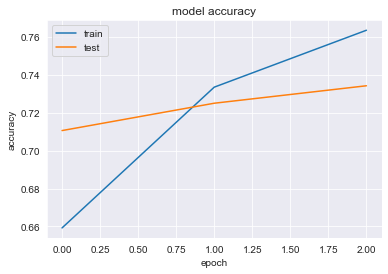

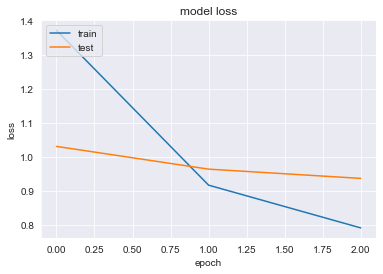

In [ ]:
# График точности модели
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# График оценки loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

================================================================================================================================================
LSTM (long short-term memory) модель
================================================================================================================================================

In [ ]:
# Преобразования текстовых данных в числовые последовательности
from keras.preprocessing.text import Tokenizer

# Создаем единый словарь (слово -> число) для преобразования
tokenizer = Tokenizer()
tokenizer.fit_on_texts(descriptions.tolist())

# Преобразуем все описания в числовые последовательности, заменяя слова на числа по словарю.
textSequences = tokenizer.texts_to_sequences(descriptions.tolist())

In [ ]:
X_train, y_train, X_test, y_test = load_data_from_arrays(textSequences, categories, train_test_split=0.8)
# Максимальное количество слов в самом длинном описании заявки
max_words = 0
for desc in descriptions.tolist():
    words = len(desc.split())
    if words > max_words:
        max_words = words
print(f'Максимальное количество слов в самом длинном описании заявки: {max_words} слов')

total_unique_words = len(tokenizer.word_counts)
print(f'Всего уникальных слов в словаре: {total_unique_words}')

maxSequenceLength = max_words

Test size: 40992

Training set:
	 - x_train: 163969
	 - y_train: 163969

Testing set:
	 - x_test: 40992
	 - y_test: 40992
Максимальное количество слов в самом длинном описании заявки: 20 слов
Всего уникальных слов в словаре: 0


In [ ]:
vocab_size = round(total_unique_words/10) #будет равен десятой части (округленной) общего числа уникальных слов (переменная используется для определения размера словаря (vocab_size) при обработке текста или обучении модели)

In [ ]:
from keras.preprocessing import sequence
import keras

print(u'Преобразуем описания заявок в векторы чисел...')
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(descriptions)

# X_train = tokenizer.texts_to_sequences(X_train)
# X_test = tokenizer.texts_to_sequences(X_test)

X_train = sequence.pad_sequences(X_train, maxlen=maxSequenceLength)
X_test = sequence.pad_sequences(X_test, maxlen=maxSequenceLength)

print('Размерность X_train:', X_train.shape)
print('Размерность X_test:', X_test.shape)

print(u'Преобразуем категории в матрицу двоичных чисел '
      u'(для использования categorical_crossentropy)')
# y_train = keras.utils.to_categorical(y_train, total_categories)
# y_test = keras.utils.to_categorical(y_test, total_categories)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Преобразуем описания заявок в векторы чисел...
Размерность X_train: (163969, 20)
Размерность X_test: (40992, 20)
Преобразуем категории в матрицу двоичных чисел (для использования categorical_crossentropy)
y_train shape: (163969,)
y_test shape: (40992,)


In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(np.concatenate([y_train, y_test]))
y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

num_classes = len(encoder.classes_) + 1
print(f'Количество категорий для классификации: {num_classes}')

Количество категорий для классификации: 227


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout

# максимальное количество слов для анализа
max_features = vocab_size
max_features = 7306
num_classes = total_categories
print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(input_dim=7307, output_dim=256, input_length=63))

# Добавляем слой LSTM
# Вы можете изменять количество нейронов (units) в зависимости от сложности задачи
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

# Добавление дополнительного слоя LSTM может улучшить результаты, но это увеличит сложность модели
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Полносвязный слой для классификации
model.add(Dense(units=100, activation='relu'))

# Выходной слой с softmax для многоклассовой классификации
model.add(Dense(units=227, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model.summary())

Собираем модель...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 63, 256)           1870592   
                                                                 
 lstm (LSTM)                 (None, 63, 100)           142800    
                                                                 
 dropout (Dropout)           (None, 63, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 100)               5100      
                                                                 
 dense_1 (Dense)             (None,

In [ ]:
X_train = list(X_train)
X_test = list(X_test)
y_train = list(y_train)
y_test = list(y_test)

In [ ]:
print("Максимальный индекс в X_train:", np.max(X_train))
print("Максимальный индекс в X_test:", np.max(X_test))
print('max_features:', max_features)

Максимальный индекс в X_train: 17966
Максимальный индекс в X_test: 12934
max_features: 7306


In [ ]:
import numpy as np
from collections import Counter

# Предполагается, что max_features уже установлено
max_features = 6616  # Пример, используйте ваше собственное значение

# 1. Считаем частоту каждого индекса в X_train
all_indices = np.concatenate(X_train)
index_counts = Counter(all_indices)

# 2. Выбираем max_features наиболее часто встречающихся индексов
most_common_indices = {index for index, _ in index_counts.most_common(max_features)}

# 3. Заменяем все нечастые индексы на 0 в X_train и X_test
X_train = np.array([[index if index in most_common_indices else 0 for index in sequence] for sequence in X_train])
X_test = np.array([[index if index in most_common_indices else 0 for index in sequence] for sequence in X_test])

In [ ]:
X_train

array([[  0,   0,   0, ...,  15,  10,   6],
       [  0,   0,   0, ..., 340, 662,   1],
       [  0,   0,   0, ..., 104,  17,   1],
       ...,
       [  0,   0,   0, ...,   1,   2,  30],
       [  0,   0,   0, ...,   2,   1,  35],
       [  0,   0,   0, ..., 120, 423,   6]])

In [ ]:
a = []
for i in y_test:
    a.append(len(i))
print(set(a))
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

TypeError: object of type 'int' has no len()

In [ ]:
max_features = 7306
X_train = np.clip(X_train, 0, max_features-1) #для уверенности, что все индексы находятся в пределах допустимого диапазона
X_test = np.clip(X_test, 0, max_features-1)

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
batch_size = 32
epochs = 3

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Тренируем модель...
Epoch 1/3


ValueError: in user code:

    File "C:\Users\4793788\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\4793788\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\4793788\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\4793788\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\4793788\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\4793788\anaconda3\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 63), found shape=(None, 20)


In [ ]:
score = model.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print()
print(u'Оценка теста: {}'.format(score[0]))
print(u'Оценка точности модели: {}'.format(score[1]))

ValueError: in user code:

    File "C:\Users\4793788\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\4793788\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\4793788\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\4793788\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\4793788\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\4793788\anaconda3\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 63), found shape=(None, 20)


KeyError: 'acc'

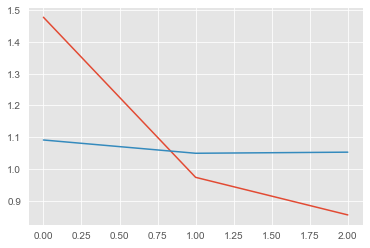

In [ ]:
# Посмотрим на эффективность обучения
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Эффективность обучения")
plt.xlabel("Повторения #")
plt.ylabel("Ошибки")
plt.legend(loc="lower left")

In [ ]:
prod = pd.read_csv(r'C:\Users\4793788\PycharmProjects\pythonProject2\TextClassifier\prod_clean_lemm.csv', encoding='utf-8', delimiter=';')
prod

,date,theme,text
0,2020-06-02,Природные ЧС / Скопления воды,затопить переход мост
1,2020-06-02,Содержание МКД / Содержание мусоропроводов,бескудниковский народный сказка сначала семь о...
2,2020-06-03,Природные ЧС / Упавшие и поваленные деревья,шипиловский упасть дерево шипиловский упасть д...
3,2020-06-03,"Содержание, устройство, покос, понижение газон...",жилищникнуть сдержать обещание благоустройство...
4,2020-06-03,Водоотведение / Прием и транспортировка сточны...,ливневка город нуждаться замена скоро канализа...
...,...,...,...
132465,2023-07-21,Водоснабжение / Горячее водоснабжение,критика повод соблюдение срок подача гвс корпу...
132466,2023-07-21,Водоотведение / Прием и транспортировка сточны...,критика повод качество работа укладка асфальт ...
132467,2023-07-21,"Благоустройство вылетных магистралей, улиц и о...",результат благоустройство двор адрес ул академ...
132468,2023-07-21,Работа управляющей компании МКД,критика повод помывка мусорный контейнер терри...


In [ ]:
prod.to_csv(r'C:\Users\4793788\PycharmProjects\pythonProject2\TextClassifier\prod_clean_lemm_vector.csv', sep=';', index=False, encoding='utf-8-sig')

In [ ]:
import re

# Функция для удаления английских слов из строки
def remove_english_words(text):
    # Регулярное выражение для нахождения английских слов
    # \b обозначает границу слова, [a-zA-Z] соответствует буквам английского алфавита
    pattern = r'\b[a-zA-Z]+\b'
    # Замена английских слов на пустую строку
    return re.sub(pattern, '', text)

# Применение функции к каждому элементу в колонке 'text'
prod['text'] = prod['text'].apply(remove_english_words)
prod.head()

,date,theme,text
0,2020-06-02,Природные ЧС / Скопления воды,затопить переход мост
1,2020-06-02,Содержание МКД / Содержание мусоропроводов,бескудниковский народный сказка сначала семь о...
2,2020-06-03,Природные ЧС / Упавшие и поваленные деревья,шипиловский упасть дерево шипиловский упасть д...
3,2020-06-03,"Содержание, устройство, покос, понижение газон...",жилищникнуть сдержать обещание благоустройство...
4,2020-06-03,Водоотведение / Прием и транспортировка сточны...,ливневка город нуждаться замена скоро канализа...


In [ ]:
prod['text'].str.split().apply(len).mean() #выражение возвращает среднюю длину слов в каждой строке

33.648765758284895

In [ ]:
count = 0
lst = []
dct = {}
while True:
    try:
        prod['text'].values[count]
        lst.append(prod['text'].values[count])
        while len(lst[count]) < 50:
            lst[count].append(0)
        count += 1
    except:
        break

arr = np.array(lst)
dct['data'] = arr

In [ ]:
lst

['затопить переход мост']

In [ ]:
# Векторизация
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10000)  # ограничение числа признаков
X = tfidf.fit_transform(prod['text'])

svd = TruncatedSVD(n_components=100)  # снижение размерности
X_reduced = svd.fit_transform(X)

prod['tfidf_vectorized_text'] = list(X_reduced)
prod['tfidf_vectorized_text'].iloc(0)[0]

array([ 0.02341263,  0.00208048, -0.00958585,  0.00264904, -0.00049459,
        0.0074442 , -0.00503305,  0.01560219, -0.04280731, -0.03757598,
       -0.03478411, -0.00714093, -0.02723887,  0.00076271,  0.00627079,
       -0.03385773,  0.00320599,  0.00171174,  0.01200925,  0.0240924 ,
       -0.01372878, -0.01156689, -0.03247846,  0.01801188,  0.01542528,
        0.00181316, -0.02412026,  0.00569631, -0.00273498,  0.00534933,
        0.01378268, -0.00148326,  0.02348947,  0.00294921, -0.01969257,
        0.00882871,  0.00798045,  0.02252285,  0.00661256,  0.06267085,
        0.0044515 ,  0.01622548,  0.00786501,  0.11858033, -0.01974006,
        0.0333417 , -0.10604387,  0.05200977,  0.0242911 ,  0.03701516,
        0.00464485,  0.02684376, -0.04849544, -0.06366033,  0.03071672,
       -0.02131093,  0.04148789, -0.00142209, -0.09697858,  0.12116228,
       -0.09715046,  0.18212414, -0.1018875 ,  0.03775159, -0.0479024 ,
       -0.03324066,  0.22544421, -0.01154288, -0.10111651,  0.04

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])
prod['vectorized_text'] = tokenizer.texts_to_sequences(data['text'])

NameError: name 'data' is not defined

In [ ]:
# Получение уникальных и отсортированных значений из 'theme'
unique_themes = sorted(prod['theme'].unique())

# Создание словаря с индексами, начинающимися с 1
theme_dict = {theme: i + 1 for i, theme in enumerate(unique_themes)}

# Вывод созданного словаря
print(theme_dict)

{'Адресные указатели': 1, 'Антропогенные ЧС / Зимние виды отдыха': 2, 'Антропогенные ЧС / Крупные ДТП': 3, 'Антропогенные ЧС / Несчастные случаи с рабочими': 4, 'Антропогенные ЧС / Открытые и сломанные люки': 5, 'Антропогенные ЧС / Падение снега и сосулек': 6, 'Антропогенные ЧС / Пропавшие на воде': 7, 'Антропогенные ЧС / Сломанные детские и спортивные площадки': 8, 'Антропогенные ЧС / Теракт (минирование)': 9, 'Антропогенные ЧС / Удары электричеством от объектов КГХ': 10, 'Антропогенные ЧС / Ямы, нарушения покрытия': 11, 'Битцевский лес': 12, 'Благоустройство ООПТ: Кусково': 13, 'Благоустройство ООПТ: Покровское-Стрешнево': 14, 'Благоустройство ООПТ: общее и прочее': 15, 'Благоустройство вылетных магистралей, улиц и общественных пространств': 16, 'Благоустройство парка Яуза': 17, 'Благоустройство парков': 18, 'Водоотведение / Очистка сточных и канализационных вод': 19, 'Водоотведение / Плановое техобслуживание и профилактика': 20, 'Водоотведение / Прием и транспортировка сточных и кан

In [ ]:
# Замена тем на соответствующие индексы
prod['theme'] = prod['theme'].apply(lambda theme: theme.replace(theme, str(theme_dict[theme])))
prod[['theme']]

,theme
0,121
1,155
2,124
3,188
4,21
...,...
132465,23
132466,21
132467,16
132468,131


In [ ]:
prod.columns

Index(['date', 'theme', 'text', 'tfidf_vectorized_text'], dtype='object')

In [ ]:
df = prod[['theme', 'tfidf_vectorized_text']]

In [ ]:
filtered_groups = []

# Группировка по темам и фильтрация
for theme, group in prod.groupby('theme'):
    if len(group) > 300:
        # Случайный выбор 300 записей для данной темы
        filtered_groups.append(group.sample(n=300, random_state=1))
    else:
        # Добавляем все записи для тем, где их менее 300
        filtered_groups.append(group)

# Объединение всех групп в один датафрейм
filtered_prod = pd.concat(filtered_groups)

# Переиндексация датафрейма
filtered_prod.reset_index(drop=True, inplace=True)

In [ ]:
# Фильтрация датафрейма
# Оставляем только те строки, где количество примеров темы больше или равно 300
filtered_prod = filtered_prod[filtered_prod['theme'].map(filtered_prod['theme'].value_counts()) >= 300]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Предположим, что filtered_prod уже загружен
# filtered_prod = pd.read_csv('your_file.csv')  # Загрузите ваш датафрейм, если он еще не загружен

# Разделение данных на признаки (X) и метки (y)
X = list(filtered_prod['tfidf_vectorized_text'])  # Убедитесь, что 'text' содержит векторизированные данные
y = filtered_prod['theme']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

# Оценка модели
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         103       0.56      0.58      0.57        57
         106       0.60      0.69      0.64        61
          11       0.47      0.50      0.49        52
         112       0.28      0.39      0.32        57
         116       0.33      0.21      0.26        62
         118       0.24      0.14      0.18        50
          12       0.64      0.84      0.72        55
         120       0.64      0.43      0.52        69
         121       0.49      0.45      0.47        62
         124       0.67      0.84      0.75        63
         130       0.57      0.88      0.69        65
         131       0.28      0.06      0.11        77
         132       0.83      0.92      0.87        63
         138       0.47      0.41      0.44        64
          14       0.88      0.93      0.90        68
         140       0.48      0.55      0.51        55
         142       0.69      0.61      0.65        59
         143       0.40    

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Предположим, что ваши текстовые данные находятся в filtered_prod['text']
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(filtered_prod['text'])
y = filtered_prod['theme']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение мультиномиального наивного байесовского классификатора
model = MultinomialNB()
model.fit(X_train, y_train)

# Оценка модели
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

NameError: name 'MultinomialNB' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Предположим, что filtered_prod уже загружен
# filtered_prod = pd.read_csv('your_file.csv')  # Загрузите ваш датафрейм, если он еще не загружен

# Разделение данных на признаки (X) и метки (y)
X = list(filtered_prod['tfidf_vectorized_text'])  # Убедитесь, что 'text' содержит векторизированные данные
y = filtered_prod['theme']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение классификатора на основе случайного леса
model = RandomForestClassifier(n_estimators=100, random_state=42)  # Вы можете настроить параметры, если это необходимо
model.fit(X_train, y_train)

# Оценка модели
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         103       0.39      0.53      0.45        57
         106       0.46      0.61      0.52        61
          11       0.27      0.40      0.32        52
         112       0.31      0.49      0.38        57
         116       0.23      0.23      0.23        62
         118       0.15      0.12      0.13        50
          12       0.64      0.87      0.74        55
         120       0.41      0.33      0.37        69
         121       0.43      0.45      0.44        62
         124       0.69      0.86      0.77        63
         130       0.60      0.86      0.71        65
         131       0.27      0.09      0.14        77
         132       0.72      0.83      0.77        63
         138       0.33      0.27      0.29        64
          14       0.90      0.93      0.91        68
         140       0.42      0.55      0.48        55
         142       0.66      0.64      0.65        59
         143       0.38    

In [ ]:
filtered_prod

,date,theme,text,tfidf_vectorized_text
488,2023-06-12,103,сообщаться повышение оплата жкх город москва о...,"[0.12692948260593656, 0.0005274292802858504, -..."
489,2021-11-29,103,критика повод начисление статья вывоз мусор со...,"[0.16163444869854493, -0.0676256848677644, 0.0..."
490,2021-11-15,103,критика новый тариф вывоз тко осуществлять ком...,"[0.10138142484149563, 0.005986839464883647, -0..."
491,2023-05-02,103,жалоба житель неправильный начисление электроэ...,"[0.07579865938894503, 0.02411356345817315, -0...."
492,2021-10-24,103,критика адрес мосэнергосбыт вопрос своевременн...,"[0.06613402462445155, 0.013100770480579633, -0..."
...,...,...,...,...
35878,2022-12-02,91,житель указать нарушение пожарный безопасность...,"[0.13465846072715373, 0.07033646816561616, 0.0..."
35879,2021-07-06,91,жалоба длительный срок устранение недостаток к...,"[0.15430518855067052, 0.08736586506962514, 0.0..."
35880,2021-04-29,91,жалоба отсутствие проведение осс вопрос капита...,"[0.169404566464889, 0.12327746466553428, 0.015..."
35881,2023-03-30,91,жалоба отсутствие проведение выездной комиссио...,"[0.08048185321412445, 0.046346918426115664, 0...."


In [ ]:
pd.DataFrame(filtered_prod['theme'].value_counts()).tail(100)

,theme
103,300
207,300
23,300
226,300
223,300
...,...
157,300
156,300
155,300
154,300


In [ ]:
# Определение порога
threshold = 6

# Подсчёт количества примеров для каждой темы
theme_counts = filtered_prod['theme'].value_counts()

# Фильтрация датафрейма
# Оставляем только те строки, где количество примеров темы больше или равно порогу
filtered_prod = filtered_prod[filtered_prod['theme'].map(theme_counts) >= threshold]

In [ ]:
from imblearn.over_sampling import SMOTE

# Выделение признаков и целевой переменной
X = np.array(list(filtered_prod['tfidf_vectorized_text']))
y = filtered_prod['theme'].values

# Создание и применение SMOTE
smote = SMOTE(sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(X, y)

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
pd.DataFrame(filtered_prod['theme'].value_counts()).head(100)

,theme
103,300
207,300
23,300
226,300
223,300
...,...
157,300
156,300
155,300
154,300


In [ ]:
filtered_prod.columns

Index(['date', 'theme', 'text', 'tfidf_vectorized_text'], dtype='object')

In [ ]:
pip install pymorphy2

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Лемматизация
import pymorphy2
from concurrent.futures import ThreadPoolExecutor

# Инициализация анализатора pymorphy2
morph = pymorphy2.MorphAnalyzer()

# Функция для лемматизации текста
def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
    return ' '.join(lemmatized_words)

# Функция для обработки пакета текстов
def process_batch(texts):
    return [lemmatize_text(text) for text in texts]

# Разбиение данных на пакеты
def batch(iterable, batch_size=100):
    l = len(iterable)
    for ndx in range(0, l, batch_size):
        yield iterable[ndx:min(ndx + batch_size, l)]

# Многопоточная обработка
batch_size = 50  # Можно настроить в зависимости от объема данных и возможностей системы
with ThreadPoolExecutor() as executor:
    results = executor.map(process_batch, batch(prod['text'], batch_size))
    # Объединение результатов
    prod['text'] = [lemmatized_text for batch_result in results for lemmatized_text in batch_result]

prod['text']

0                                     затопить переход мост
1         бескудниковский народный сказка сначала семь о...
2         шипиловский упасть дерево шипиловский упасть д...
3         жилищникнуть сдержать обещание благоустройство...
4         ливневка город нуждаться замена скоро канализа...
                                ...                        
132465    критика повод соблюдение срок подача гвс корпу...
132466    критика повод качество работа укладка асфальт ...
132467    результат благоустройство двор адрес ул академ...
132468    критика повод помывка мусорный контейнер терри...
132469    сообщаться слив химикат пруд около мгс район я...
Name: text, Length: 132470, dtype: object

In [ ]:
len(prod['text'].unique())

132322

In [ ]:
prod['text'] = prod['text'].apply(lambda x: x.split(' '))

In [ ]:
prod

,date,theme,text,tfidf_vectorized_text
0,2020-06-02,121,"[затопить, переход, мост]","[0.02341262872147978, 0.0020804805230502325, -..."
1,2020-06-02,155,"[бескудниковский, народный, сказка, сначала, с...","[0.030132991430746475, -0.022740252650806928, ..."
2,2020-06-03,124,"[шипиловский, упасть, дерево, шипиловский, упа...","[0.07016726318697752, -0.052754720715364196, -..."
3,2020-06-03,188,"[жилищникнуть, сдержать, обещание, благоустрой...","[0.0958306908959486, -0.038505324211720746, -0..."
4,2020-06-03,21,"[ливневка, город, нуждаться, замена, скоро, ка...","[0.13440047240246594, 0.0011617256539806103, 0..."
...,...,...,...,...
132465,2023-07-21,23,"[критика, повод, соблюдение, срок, подача, гвс...","[0.07306550642318951, 0.04404124734676112, 0.0..."
132466,2023-07-21,21,"[критика, повод, качество, работа, укладка, ас...","[0.14604242044950455, 0.07987600864957181, -0...."
132467,2023-07-21,16,"[результат, благоустройство, двор, адрес, ул, ...","[0.20901720725544357, -0.008970419556283058, -..."
132468,2023-07-21,131,"[критика, повод, помывка, мусорный, контейнер,...","[0.18566314450193314, -0.022104834302974323, -..."


In [ ]:
descriptions = prod['text']
categories = prod['theme']

max_words = 0
for desc in descriptions:
    words = len(desc)
    if words > max_words:
        max_words = words
print('Максимальная длина описания: {} слов'.format(max_words))

maxSequenceLength = 209

Максимальная длина описания: 208 слов


In [ ]:
set(prod['theme'].unique()) - set(themes['theme'].unique())

{'1',
 '10',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '11',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '12',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '13',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '14',
 '140',
 '141',
 '142',
 '143',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '15',
 '150',
 '151',
 '152',
 '153',
 '154',
 '155',
 '156',
 '157',
 '158',
 '159',
 '16',
 '160',
 '161',
 '162',
 '163',
 '164',
 '165',
 '166',
 '167',
 '168',
 '169',
 '17',
 '170',
 '171',
 '172',
 '173',
 '174',
 '175',
 '176',
 '177',
 '178',
 '179',
 '18',
 '180',
 '181',
 '182',
 '183',
 '184',
 '185',
 '186',
 '187',
 '188',
 '189',
 '19',
 '190',
 '191',
 '192',
 '193',
 '194',
 '195',
 '196',
 '197',
 '198',
 '199',
 '2',
 '20',
 '200',
 '201',
 '202',
 '203',
 '204',
 '205',
 '206',
 '207',
 '208',
 '209',
 '21',
 '210',
 '211',
 '212',


In [ ]:
# Векторизация текста
vectorizer = TfidfVectorizer(max_features=10000)  # Можно настроить параметры
X = vectorizer.fit_transform(prod['text'])

AttributeError: 'list' object has no attribute 'lower'

In [ ]:
prod

,date,theme,text,tfidf_vectorized_text
0,2020-06-02,121,"[затопить, переход, мост]","[0.02341262872147978, 0.0020804805230502325, -..."
1,2020-06-02,155,"[бескудниковский, народный, сказка, сначала, с...","[0.030132991430746475, -0.022740252650806928, ..."
2,2020-06-03,124,"[шипиловский, упасть, дерево, шипиловский, упа...","[0.07016726318697752, -0.052754720715364196, -..."
3,2020-06-03,188,"[жилищникнуть, сдержать, обещание, благоустрой...","[0.0958306908959486, -0.038505324211720746, -0..."
4,2020-06-03,21,"[ливневка, город, нуждаться, замена, скоро, ка...","[0.13440047240246594, 0.0011617256539806103, 0..."
...,...,...,...,...
132465,2023-07-21,23,"[критика, повод, соблюдение, срок, подача, гвс...","[0.07306550642318951, 0.04404124734676112, 0.0..."
132466,2023-07-21,21,"[критика, повод, качество, работа, укладка, ас...","[0.14604242044950455, 0.07987600864957181, -0...."
132467,2023-07-21,16,"[результат, благоустройство, двор, адрес, ул, ...","[0.20901720725544357, -0.008970419556283058, -..."
132468,2023-07-21,131,"[критика, повод, помывка, мусорный, контейнер,...","[0.18566314450193314, -0.022104834302974323, -..."


In [ ]:
prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132470 entries, 0 to 132469
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   date                   132470 non-null  object
 1   theme                  132470 non-null  object
 2   text                   132470 non-null  object
 3   tfidf_vectorized_text  132470 non-null  object
dtypes: object(4)
memory usage: 4.0+ MB


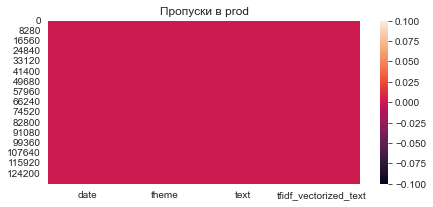

In [ ]:
# Проверка на наличие пропусков в prod
plt.figure(figsize=(7, 3))
sns.heatmap(prod.isnull())
plt.title('Пропуски в prod')
plt.show()

In [ ]:
pd.Series(prod['theme'].unique())
# themes['theme'].unique()

0      121
1      155
2      124
3      188
4       21
      ... 
224     64
225    123
226    133
227    221
228     29
Length: 229, dtype: object

In [ ]:
# Получаем уникальные значения из обоих столбцов
prod_unique = pd.Series(prod['theme'].unique())
themes_unique = pd.Series(themes['theme'].unique())

# Находим общие и непарные значения
common_values = pd.Series(list(set(prod_unique) & set(themes_unique)))
prod_diff = pd.Series(list(set(prod_unique) - set(common_values)))
themes_diff = pd.Series(list(set(themes_unique) - set(common_values)))

# Создаем датафрейм с парными значениями
paired_values = pd.DataFrame({
    'prod_theme': common_values.reindex(range(max(len(prod_diff), len(themes_diff)))),
    'themes_theme': common_values.reindex(range(max(len(prod_diff), len(themes_diff))))
})

# Добавляем непарные значения в датафрейм
paired_values['prod_theme'][len(common_values):] = prod_diff.values
paired_values['themes_theme'][len(common_values):] = themes_diff.values

# Сохраняем в CSV
paired_values.to_csv(r'C:\Users\MKW\Downloads\Telegram Desktop\common_themes.csv', sep=';', index=False, encoding='utf-8-sig')

C:\Users\4793788\AppData\Local\Temp\ipykernel_7752\2410444625.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  common_values = pd.Series(list(set(prod_unique) & set(themes_unique)))
C:\Users\4793788\AppData\Local\Temp\ipykernel_7752\2410444625.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paired_values['themes_theme'][len(common_values):] = themes_diff.values


ValueError: cannot set using a slice indexer with a different length than the value

In [ ]:
def merge_lists(prod, themes):
    # Создаем множества из элементов списков
    set_prod = set(prod)
    set_themes = set(themes)

    # Объединяем множества для получения всех уникальных элементов
    unique_elements = set_prod.union(set_themes)

    # Создаем результирующий список
    result = []
    for element in unique_elements:
        # Добавляем пары значений в результирующий список
        result.append([element if element in set_prod else '', element if element in set_themes else ''])

    return result

print(merge_lists(prod['theme'].unique(), themes['theme'].unique()))

[['', 'Содержание, устройство, покос, понижение газонов / Покос газона'], ['', 'Содержание, ремонт и обеспечение приютов для безнадзорных животных / Волонтеры'], ['108', ''], ['', 'Капитальный ремонт МКД / Ремонт балконов МКД'], ['', 'Контейнерные площадки'], ['110', ''], ['189', ''], ['', 'Критика ответа'], ['', 'Техногенные ЧС / Пожар'], ['', 'Теплоснабжение (центральное отопление) / Подготовка жилого фонда к отопительному сезону, опрессовка'], ['', 'Состояние рек / Сбросы '], ['', 'Содержание ООПТ'], ['', 'Природные ЧС / Провал, размытие грунта'], ['219', ''], ['10', ''], ['71', ''], ['194', ''], ['', 'Содержание, устройство, покос, понижение газонов / Содержание газона, подсев'], ['', 'Дорожная разметка / Иные проблемы разметки'], ['195', ''], ['', 'Природные ЧС / Удар молнией'], ['49', ''], ['', 'Демонтаж, ремонт и установка утилитарного наружного освещения / Установка уличного освещения'], ['', 'Вырубка и обрезка деревьев / Компенсационное озеленение'], ['', 'Демонтаж, ремонт и у

In [ ]:
import csv

result = merge_lists(prod['theme'].unique(), themes['theme'].unique())

# Указываем путь к файлу
file_path = r'C:\Users\4793788\PycharmProjects\pythonProject2\TextClassifier\common_themes.csv'

# Записываем данные в CSV
with open(file_path, 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # Записываем каждую пару в отдельной строке
    for row in result:
        writer.writerow(row)

# Убедитесь, что файл успешно записан
print("Файл успешно сохранен.")

Файл успешно сохранен.


In [ ]:
set_prod = set(prod_new['theme'].unique())
set_themes = set(themes['theme'].unique())

# Нахождение пересечения
intersection = set_prod - set_themes

# Преобразование обратно в список, если это необходимо
result = list(intersection)

k = 110
print(list(intersection))

NameError: name 'prod_new' is not defined

In [ ]:
for i in pd.Series(prod_unique).sort_values():
    print(i)

nan
Адресные указатели
Антропогенные ЧС / Зимние виды отдыха
Антропогенные ЧС / Крупные ДТП
Антропогенные ЧС / Несчастные случаи с рабочими
Антропогенные ЧС / Открытые и сломанные люки
Антропогенные ЧС / Падение снега и сосулек
Антропогенные ЧС / Пропавшие на воде
Антропогенные ЧС / Сломанные детские и спортивные площадки
Антропогенные ЧС / Теракт (минирование)
Антропогенные ЧС / Удары эклектричеством от объектов КГХ
Антропогенные ЧС / Удары электричеством от объектов КГХ
Антропогенные ЧС / Ямы, нарушения покрытия
Битцевский лес
Благоустройство ООПТ: Кусково
Благоустройство ООПТ: Покровское-Стрешнево
Благоустройство ООПТ: общее и прочее
Благоустройство вылетных магистралей, улиц и общественных пространств
Благоустройство парка Яуза
Благоустройство парков
Благоустройство парков
Борщевик
Водоотведение / Очистка сточных и канализационных вод
Водоотведение / Плановое техобслуживание и профилактика
Водоотведение / Прием и транспортировка сточных и канализационных вод, ливневки
Водоотведение